<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# Group members

* Castillo, Galo
* Guaranda, Maria
* Shahid, Abdurrahman


# Presentation of the challenge

## Main question of this challenge

* How to predict the survival of a patient according to their medical files and physiological data?
    
* Specifically, you will need to predict it during their hospital stay
 
Every day, the nursing staff collects information about the patients by asking questions and using measurement tools (stethoscope, blood test, sensors, etc.). These data are very useful for monitoring the state of health, diagnosing, and choosing treatments.

They can also be used for predictive statistical analysis.

## Data

The dataset contains information on 80,000 patients, represented by categorical, binary and, numeric variables (features). These variables are, e.g., age, sex, ethnicity, marital status, as well as medical data such as blood pressure or glucose level. There are a total of 342 variables.

The class to predict is a binary variable indicating whether the patient died or not during his stay in the hospital. Fortunately, most survive.

References and credit:

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

In [112]:
import platform

from datetime import datetime
from pathlib import Path
from zipfile import ZipFile

import imblearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

import warnings
from collections import Counter

from sklearn.feature_selection import chi2

from sklearn.preprocessing import LabelEncoder
from category_encoders import *
from sklearn.impute import SimpleImputer

import xgboost as xgb
import lightgbm

import optuna

In [2]:
%reload_ext autoreload
%autoreload 2

if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.0.1

0.24.2


In [3]:
plt.rcParams['figure.figsize'] = [9, 5]

# Show all the columns and rows of dataframes/series.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

## 1. Understanding the problem

### Metric

Why the metric used here is the [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) rather than simply [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

According to the official sklearn documentation, the [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) metric works better for imbalanced classification problems, than [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html). Such difference occurs because the latest simply returns the percentage of labels you predicted correctly, while the former returns the average accuracy per class (i.e. the [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) would give more importance to correctly classifying the majority class in imbalanced classification, and [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) would give the same importance to classifying correctly both classes.)

## 2. Data loading

In [4]:
DATA = Path("./public_data")

PRED_PATH = Path("Submissions")

DROP_FTS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [5]:
features = pd.read_csv(DATA / "mimic_synthetic_feat.name", header=None).values.flatten()

labels = pd.read_csv(DATA / "mimic_synthetic_label.name", header=None).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_FTS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)


In [6]:
#Check how the train data looks like
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,DIAS_BP_MEAN_DAY1,MEAN_BP_MIN_DAY1,MEAN_BP_MAX_DAY1,MEAN_BP_MEAN_DAY1,RESP_RATE_MIN_DAY1,RESP_RATE_MAX_DAY1,RESP_RATE_MEAN_DAY1,TEMP_MIN_DAY1,TEMP_MAX_DAY1,TEMP_MEAN_DAY1,SPO2_MIN_DAY1,SPO2_MAX_DAY1,SPO2_MEAN_DAY1,GLUCOSE_MIN_DAY1,GLUCOSE_MAX_DAY1,GLUCOSE_MEAN_DAY1,HR_MIN_DAY2,HR_MAX_DAY2,HR_MEAN_DAY2,SYS_BP_MIN_DAY2,SYS_BP_MAX_DAY2,SYS_BP_MEAN_DAY2,DIAS_BP_MIN_DAY2,DIAS_BP_MAX_DAY2,DIAS_BP_MEAN_DAY2,MEAN_BP_MIN_DAY2,MEAN_BP_MAX_DAY2,MEAN_BP_MEAN_DAY2,RESP_RATE_MIN_DAY2,RESP_RATE_MAX_DAY2,RESP_RATE_MEAN_DAY2,TEMP_MIN_DAY2,TEMP_MAX_DAY2,TEMP_MEAN_DAY2,SPO2_MIN_DAY2,SPO2_MAX_DAY2,SPO2_MEAN_DAY2,GLUCOSE_MIN_DAY2,GLUCOSE_MAX_DAY2,GLUCOSE_MEAN_DAY2,ICU,Tuberculosis,Immuniz/scrn,AcuteMI,Coronathero,Chestpain,Pulmhartdx,Othheartdx,Conduction,Dysrhythmia,Cardiaarrst,chf;nonhp,AcuteCVD,Hd/nckcancr,Precereoccl,OtherCVD,TIA,LateeffCVD,Peripathero,Aneurysm,Artembolism,Otcirculdx,Phlebitis,Varicosevn,Esophcancer,Hemmorhoids,Othveindx,Pneumonia,Influenza,Tonsillitis,Bronchitis,Otuprspin,COPD,Asthma,Asppneumon,Stomchcancr,Pleurisy,Adltrespfl,Lungexternl,Othlowresp,Otupprresp,Intestinfct,Teethdx,Mouthdx,Esophgealdx,Gasduoulcer,Coloncancer,Gastritis,Otdxstomch,Appendicitis,Abdomhernia,Ulceratcol,Intobstruct,Diverticulos,Anal/rectal,Peritonitis,Biliarydx,Rctm/anusca,Othliverdx,Pancreasdx,GIhemorrhag,Gastroent,OtherGIdx,Nephritis,Acrenlfail,Chrrenfail,UTI,Liver/ibdca,Urinstone,Otdxkidney,Otdxbladdr,OtherGUdx,BPH,Infmalegen,Othmalegen,Breastdx,PID,Endometrios,Pancreascan,Prolapse,Menstrualdx,Ovariancyst,Menopausldx,Feminfertil,Otfemalgen,Contraceptiv,Spontabortn,Inducabortn,Abortcompl,GI/peritcan,Ectopicpreg,Otpregcomp,Hemorrpreg,HTNinpreg,Earlylabor,Longpregncy,DMinpreg,Malposition,Pelvicobstr,Prevc-sectn,Brnch/lngca,Fetaldistrs,Amniosdx,Umbilcord,OB-relatedperintrauma,Otcomplbir,Nmlpreg/del,Skininfectn,Otinflskin,Ulcerskin,Septicemia,Otrespirca,Othskindx,Infectarth,Rheumarth,Osteoarthros,Otjointdx,Backproblem,Osteoporosis,Pathologfx,Acqfootdef,Otacqdefor,Bone/ctcncr,SLE,Otconntiss,Otbonedx,Cardiacanom,GIconganom,guconganom,Nervcongan,Otconganom,Liveborn,Lowbirthwt,Skinmelanom,Birthasphyx,Respdistres,Perintjaund,Birthtrauma,Otperintdx,Jointinjury,Fxhip,Spincorinj,Fxskullfac,Fxarm,Non-epithca,Fxleg,Othfracture,Sprain,Intracrninj,Crushinjury,Opnwndhead,Opnwndextr,Complicdevi,Complicproc,Superficinj,Breastcancr,Burns,Poisonpsych,Poisnotmed,Poisnnonmed,Otherinjury,Syncope,FUO,Lymphenlarg,Gangrene,Shock,Uteruscancr,Nausea/vomit,Abdomnlpain,Fatigue,Allergy,Socialadmin,Exam/eval,Otaftercare,Otherscreen,Unclassified,Cervixcancr,ECodes:Cut/pierce,ECodes:Drowning/submersion,ECodes:Fall,ECodes:Fire/burn,ECodes:Firearm,ECodes:Machinery,ecodes:motorvehicletraffic(mvt),ECodes:Pedalcyclist-notMVT,ECodes:Pedestrian-notMVT,ecodes:transport-notmvt,ECodes:Natural/environment,ECodes:Overexertion,ECodes:Poisoning,ECodes:Struckby-against,ECodes:Suffocation,ECodes:Adverseeffectsofmedicalcare,ECodes:Adverseeffectsofmedicaldrugs,ECodes:Otherspecifiedandclassifiable,ecodes:otherspecified-nec,ECodes:Unspecified,ECodes:Placeofoccurrence,Ovarycancer,Femgenitca,Prostatecan,Othbactinf,Testiscancr,Malgenitca,Bladdercncr,Kidny/rnlca,Urinyorgca,Brain/nscan,Thyroidcncr,Hodgkin-sds,Non-Hodglym,Leukemias,Mycoses,Multmyeloma,Otprimryca,2ndarymalig,Maligneopls,Neoplsmunsp,Maintchem/r,Bnignutneo,Otbnignneo,Thyroiddsor,DiabMelnoc,HIVinfectn,DiabMelw/cm,Otendodsor,Nutritdefic,Hyperlipidem,Gout/otcrys,Fluid/elcdx,Cysticfibro,Immunitydx,Otnutritdx,Anemia,Hepatitis,Acutp-hanm,Sicklecell,Coag/hemrdx,Whtblooddx,Othematldx,Adjustmentdisorders,Anxietydisorders,Attention-deficit/conduct/disruptivebeha,Delirium/dementia/amnestic/othercognitiv,Developmentaldisorders,Disordersusuallydiagnosedininfancy/ch,ImpulsecontroldisordersNEC,Mooddisorders,Personalitydisorders,Schizophreniaandotherpsychoticdisorde,Alcohol-relat

#### Target Distribution

Text(0.5, 0, 'Died')

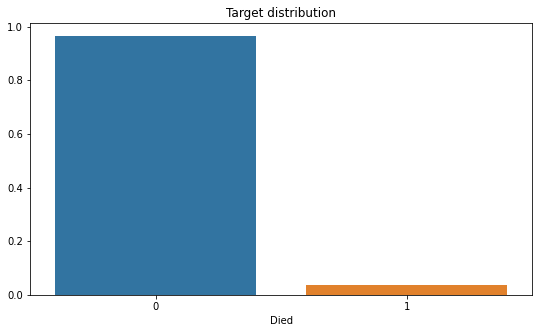

In [22]:
#Check the class imbalancement in the training set
sns.barplot(x=ys.value_counts(normalize=True).index, y=ys.value_counts(normalize=True))
plt.title('Target distribution')
plt.xlabel('Died')

In [23]:
ys.value_counts(normalize=True)

0     0.965
1   0.03496
dtype: float64

The target distribution visualization shows that there is a **high class imbalance** in our data. In fact, the positive label (the patient died) represents only the **3.5% of the records** approximately. This is why we will use the **balanced accuracy** as the performance metric.

In [7]:
ys.value_counts()

0    77202
1     2797
dtype: int64

In [9]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_FTS, inplace=True)

In [10]:
x_test_df.shape

(20001, 337)

## 3. Exploratory analysis

In [11]:
def get_types_info(x_train_df, x_test_df, types):
    """
    This is a helper function. It outputs several objects that help us to explore the different variable types
    present in the training dataset.
    input:
           x_train_df: a DataFrame object containing training data
           x_test_df: a DataFrame object containing test data
           types: type of the variables
    output:
           cagegorical_vars: a list containing the names of categorical features
           binary_vars: a list containing the names of binary features
           numerical_vars: a list containing the names of numerical features
           var_info: a DataFrame object containing for each variable its type, and the number of distinct values 
           it can take
    """

    # var_type will contain for each variable its type.
    # It will be used during data processing

    var_type = {}
    for t in ['Numerical','Binary','Categorical']:
        for var_name in types[types==t].index:
            var_type[var_name] = t
            
    # this dataframe will contain for each variable its type and the number of different
    # values it can take.
    var_info = pd.DataFrame(index=x_train_df.columns)
    var_info["Type_var"] = [var_type.get(var_name) for var_name in var_info.index]
    var_info["#Value_counts"] = [
        len(x_df[var_name].value_counts().index) for var_name in var_info.index
    ]
    
    # lists of names of categorical, binary and numericales variables
    categorical_vars = var_info[var_info['Type_var'] == 'Categorical'].index.tolist()
    binary_vars = var_info[var_info['Type_var'] == 'Binary'].index.tolist()
    numerical_vars = var_info[var_info['Type_var'] == 'Numerical'].index.tolist()
    
    assert x_train_df.columns.tolist() == x_test_df.columns.tolist(), "train and test df feature mismatch"
    
    return categorical_vars, binary_vars, numerical_vars, var_info

### Features' types

In [17]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

In [18]:
categorical_vars, binary_vars, numerical_vars, var_info = get_types_info(x_df, x_test_df, types)

To check if there are classes that need to be merged, we focus on variables other than the numerical ones, as well as considering categories with more than two different values.

In [20]:
mask_var_info = np.logical_and(var_info["Type_var"] != "Numerical",var_info["#Value_counts"] > 2)
var_info[mask_var_info]

,Type_var,#Value_counts
INSURANCE,Categorical,5
LANGUAGE,Categorical,68
RELIGION,Categorical,20
MARITAL_STATUS,Categorical,7
ETHNICITY,Categorical,41
ICU,Categorical,5


Also, we check all the columns containing only one (distinct) value.

In [21]:
mask_constant_values = var_info["#Value_counts"] == 1
var_info[mask_constant_values]

,Type_var,#Value_counts
Tuberculosis,Numerical,1
Immuniz/scrn,Numerical,1
Chestpain,Numerical,1
Othheartdx,Numerical,1
Hd/nckcancr,Numerical,1
OtherCVD,Numerical,1
TIA,Numerical,1
Artembolism,Numerical,1
Varicosevn,Numerical,1
Esophcancer,Numerical,1


We see that there are several features that have only one distinct value. These features would not be useful for our modeling task.

#### Categorical Variables Visualizations

Text(0.5, 1.0, 'ICU')

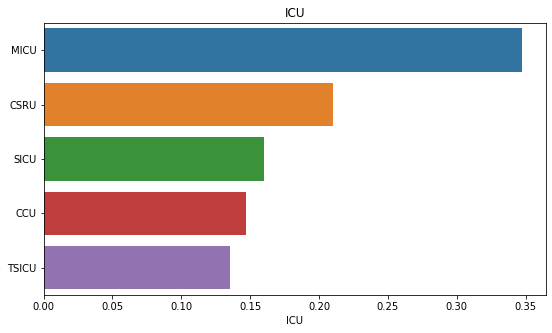

In [29]:
sns.barplot(x=x_df['ICU'].value_counts(normalize=True), y=x_df['ICU'].value_counts(normalize=True).index)
plt.title('ICU')

In [30]:
x_df.ICU.value_counts(normalize=True)

MICU    0.3473
CSRU    0.2099
SICU      0.16
CCU     0.1471
TSICU   0.1357
Name: ICU, dtype: float64

Text(0.5, 1.0, 'Language')

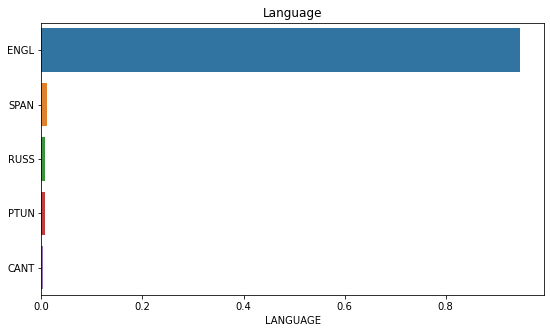

In [31]:
sns.barplot(x=x_df['LANGUAGE'].value_counts(normalize=True)[:5], y=x_df['LANGUAGE'].value_counts(normalize=True)[:5].index)
plt.title('Language')

In [32]:
x_df.LANGUAGE.value_counts(normalize=True).head()*100

ENGL    94.67
SPAN    1.089
RUSS   0.7275
PTUN   0.6925
CANT   0.3825
Name: LANGUAGE, dtype: float64

### Correlation with Target

##### Numerical Features

To detect if there is any relationship between our binary target and numerical features we use an Spearman correlation. Also we check the relationship between independent variables, since we create a heatmap.

<AxesSubplot:>

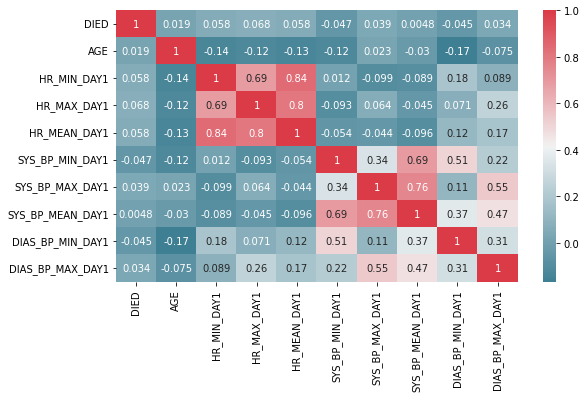

In [40]:
df_tmp = pd.concat([ys, x_df[numerical_vars]], axis = 1)
df_tmp.rename({0:'DIED'}, inplace = True, axis = 1)
corr_df = df_tmp.iloc[:,0:10].corr(method='spearman')
sns.heatmap(corr_df, 
            xticklabels=corr_df.columns.values,
            yticklabels=corr_df.columns.values,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            annot=True)

##### Categorical Features

We use a Chi-square test to determine if there is any relationship among categorical/binary features and our binary target. We use the Chi-square test to check if there is no evidence our binary target is independent of a given categorical feature. We execute the test for every categorical/binary feature.

In [41]:
# We use a LabelEncoder to encode our categorical variables just for the chi-square test,
# since the function we will use needs categorical variables to be numerically encoded.
label_encoder = LabelEncoder()
x_df_tmp = x_df.copy()
ys_tmp = ys.copy()

# Due to the low number of records with NaN values, we remove them temporally just for 
# using the chu-square test, since the function we will use does not handle missing values.
nan_indeces = x_df_tmp[x_df_tmp.isnull().any(axis=1)].index
x_df_tmp.drop(nan_indeces, axis=0, inplace=True)
ys_tmp.drop(nan_indeces, axis=0, inplace=True)

x_df_tmp['GENDER'].replace({'M': '0', 'F': '1'}, inplace=True)
x_df_tmp['GENDER'] = x_df_tmp['GENDER'].astype(float)

x_df_tmp[categorical_vars] = x_df_tmp[categorical_vars].apply(LabelEncoder().fit_transform)

In [42]:
chi_scores = chi2(x_df_tmp[categorical_vars + binary_vars], ys_tmp)
ch2_pv = pd.DataFrame({'features': categorical_vars + binary_vars, 'p_values': chi_scores[1]})
ch2_pv.sort_values(by='p_values', ascending=False , inplace=True)
ch2_pv

,features,p_values
103,Paralysis,0.9228
38,Biliarydx,0.8994
20,Phlebitis,0.8954
0,INSURANCE,0.893
1,LANGUAGE,0.8895
33,Otdxstomch,0.849
15,Precereoccl,0.849
32,Gastritis,0.849
106,Retinaldx,0.849
107,Glaucoma,0.849


The alternate hypothesis of the Chi-square test states that our two variables (a given categorical/binary feature and our target) are dependent. Then, categorical/binary features with low p-value are likely to be relevant for our classification task, whereas features with **large p-value show low evidence they are related with our target.**

We also make some cross-tabulations to see if there are categories with high or low dead rate. We will mainly check that for the features with the largest and lowest p-values from the previous Chi-square tests.

In [43]:
pd.crosstab(x_df_tmp['Paralysis'], ys_tmp, colnames=['Died'], margins=True, normalize='index')

Died,0,1
Paralysis,,
0,0.965,0.03497
1,0.9615,0.03846
All,0.965,0.03497


In [47]:
pd.crosstab(x_df_tmp['Coag/hemrdx'], ys_tmp, colnames=['Died'], margins=True, normalize='index')

Died,0,1
Coag/hemrdx,,
0,0.9673,0.03274
1,0.9187,0.08125
All,0.965,0.03497


We see that there is relatively low difference between the two binary values of the features (Paralysis, Biliarydx) with the largest p-values from the Chi-square test we executed previously, compared to the features with the lowest p-values (Adltrespfl, Coag/hemrdx)

#### Other visualizations

We compare the distributions of some continous features, to detect any difference between the two groups (patients who died and did not).

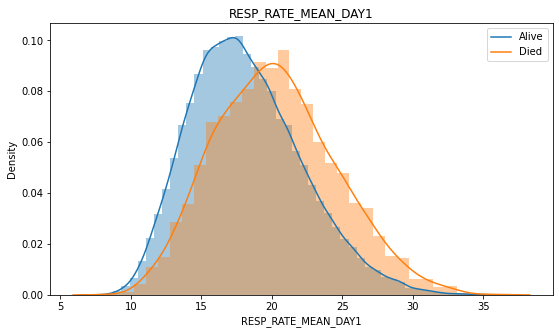

In [50]:
sns.distplot(x_df[ys == 0]['RESP_RATE_MEAN_DAY1'])
sns.distplot(x_df[ys == 1]['RESP_RATE_MEAN_DAY1'])
plt.title('RESP_RATE_MEAN_DAY1')
plt.legend(['Alive', 'Died'])

We see that people who did not died are more likely to have a lower **RESP_RATE_MEAN_DAY1** value than those who died (i.e. the distribution of the latest is centered more to the right than the former group.)

## 4. Preprocessing

### Code: Missing values handling

The simplest solution is to eliminate all the columns where there is missing data, but a large part of the information may be lost.

If a small number of instances is concerned, it is more pertinent to delete the rows (instances) rather than the entire columns (variables). But you need to **pay attention**, if you **cannot** change the number of rows in the **test set**, or the competition grader will **fail**.

A third solution would be to replace undefined values with the most probable value of the variable. As these missing values relate exclusively to categorical and binary variables, the most probable value is the [*mode*](https://en.wikipedia.org/wiki/Mode_(statistics)).

A first baseline version is given, but it should be improved. It discards all categorical features and instances with NAN.

#### Exploration

First check the number of missing data per features and per instances (patient). Don't forget to process both the training and the test sets!

<span style="color:red">Implement your solution below</span>

We check the amount of missing values for every feature. We order from the one with the largest number of missing values to those without missing values. We do the same for train and test sets.

In [51]:
x_df.isna().sum().sort_values(ascending=False).head(10)

ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
ICU                                   2
LANGUAGE                              1
Othnervdx                             1
MARITAL_STATUS                        1
Pancreasdx                            0
Intobstruct                           0
Diverticulos                          0
Anal/rectal                           0
dtype: int64

In [52]:
x_test_df.isna().sum().sort_values(ascending=False).head(10)

ECodes:Adverseeffectsofmedicalcare    3
LANGUAGE                              2
Htncomplicn                           0
GIhemorrhag                           0
Intobstruct                           0
Diverticulos                          0
Anal/rectal                           0
Peritonitis                           0
Biliarydx                             0
Rctm/anusca                           0
dtype: int64

We see that only 6 features (out of 337) in the training set and 2 in the test set contain NaN values. Moreover, the feature with the largest amount of NaN values in the test set (ECodes:Adverseeffectsofmedicalcare) contains only 6 records (out of 80K) with missin values. All the features containing missing values are categorical/binary.

#### Fixing

Now you can apply your chosen strategy

In [13]:
def impute_with_mode(x_train_df, x_test_df, colums_to_impute):
    """ 
    This function fits on the training data to select the most frequent values for every element
    in columns_to_impute. Then it imputes the missing values on the training and test sets.
    
    input:
           x_train_df: a DataFrame object containing training data
           x_test_df: a DataFrame object containing test data
           colums_to_impute: a list of features names that indicates which features will be imputed
    """

    imp = SimpleImputer(strategy='most_frequent')
    x_train_df[colums_to_impute] = imp.fit_transform(x_train_df[colums_to_impute])
    x_test_df[colums_to_impute] = imp.transform(x_test_df[colums_to_impute])
    
    return

The strategy we choose to impute missing values is the mode.

In [53]:
colums_to_impute = ['ECodes:Adverseeffectsofmedicalcare', 'Otnutritdx', 'ICU', 'LANGUAGE', 'Othnervdx', 'MARITAL_STATUS']
impute_with_mode(x_df, x_test_df, colums_to_impute)

### Reduce data scarcity (not enough data per class)

For example, you could simplify data by grouping rare categories.

In [14]:
def merge_rare_categories(x):
    """Merge rare categories in input=x. The merging is done inplace, thus this function returns None"""
    
    x.loc[~x['LANGUAGE'].isin(['ENGL']), 'LANGUAGE'] = 'RARE_LANGUAGE'
    x.loc[~x['RELIGION'].isin(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER', 'JEWISH']), 'RELIGION'] = 'RARE_RELIGION'
    x.loc[~x['MARITAL_STATUS'].isin(['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED']), 'MARITAL_STATUS'] = 'RARE_MARITAL_STATUS'
    x.loc[~x['ETHNICITY'].isin(['WHITE', 'UNKNOWN/NOT_SPECIFIED', 'BLACK/AFRICAN_AMERICAN', 'OTHER', 'HISPANIC_OR_LATINO', 'ASIAN']), 'ETHNICITY'] = 'RARE_ETHNICITY'
    return None

In order to group rare categories on categorical features, we consider the barplots previously generated.

In [54]:
merge_rare_categories(x_df)
merge_rare_categories(x_test_df)

### Transforming categorical data into integers

In [12]:
def recode_gender(x):
    """Recode the gender in dataframe x. Male is encoded by 0. Female is encoded by 1."""
    
    x['GENDER'].replace({'M': '0', 'F': '1'}, inplace=True)
    x['GENDER'] = x['GENDER'].astype('int64')
    return

First we transform to numeric the GENDER binary variable.

In [55]:
recode_gender(x_df)
recode_gender(x_test_df)

In [56]:
x_test_df[categorical_vars].head()

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,ICU
0,Self_Pay,ENGL,RARE_RELIGION,MARRIED,WHITE,SICU
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,MICU
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,SICU
3,Private,ENGL,RARE_RELIGION,MARRIED,WHITE,CSRU
4,Medicare,ENGL,JEWISH,WIDOWED,WHITE,CSRU


In [16]:
def target_encode(x_train_df, x_test_df, y, cat_features):
    """ This function encodes categorical features using Target Encoding. Firstly, 
    the function fits on the training data. Then it encodes the training and test sets.
    
    input:
        x_train_df: a DataFrame object containing training data
        x_test_df: a DataFrame object containing test data
        cat_features: a list containing the categorical features to be encoded from x
    """

    encoder = TargetEncoder(cols=categorical_vars)
    x_train_df[cat_features] = encoder.fit_transform(x_train_df[cat_features], y)
    x_test_df[cat_features] = encoder.transform(x_test_df[cat_features], override_return_df=True)
    
    return

We choose the Target Encoding technique to encode our categorical data.

In [57]:
target_encode(x_df, x_test_df, ys, categorical_vars)

In [58]:
x_test_df[categorical_vars].head()

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,ICU
0,0.06156,0.0356,0.03444,0.03465,0.03509,0.0332
1,0.04269,0.0356,0.03415,0.03412,0.03416,0.0428
2,0.02021,0.0356,0.03347,0.03412,0.03509,0.0332
3,0.02387,0.0356,0.03444,0.03465,0.03509,0.03097
4,0.04269,0.0356,0.0373,0.0368,0.03509,0.03097


#### Removing single-valued variables (constants)

In [15]:
def remove_columns(x, feat_to_remove=None):
    """Remove colums in input=feat_to_remove from input=x.
    input:
       x: a DataFrame object
       feat_to_remove: a list containing the columns to remove/delete from x
    """
    x.drop(feat_to_remove, axis=1, inplace=True)
    return

In [66]:
constant_features = var_info[mask_constant_values].index.tolist()
print('Amount of constant features:', len(constant_features))

Amount of constant features: 173


In [68]:
remove_columns(x_df, constant_features)
remove_columns(x_test_df, constant_features)

### Creation of the validation set

In [71]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_df, ys, test_size=0.30, random_state=0
)

### Size reduction via PCA

Test the PCA to reduce the number of dimensions and see if this improves the result.

Before applying the PCA, it is advisable to standardize the data.

In [73]:
N_COMPS_PCA = 50

scaler = preprocessing.MinMaxScaler()
xt_scaled = scaler.fit_transform(x_train)
xv_scaled = scaler.transform(x_valid)

pca = decomposition.PCA(n_components=N_COMPS_PCA)
pca.fit(xt_scaled)
xt_pca = pca.transform(xt_scaled)
xv_pca = pca.transform(xv_scaled)

Print a graph that represents the first 2 dimensions of PCA and comment briefly.

Text(0.5, 1.0, 'Principal Components Analysis (Two main components)')

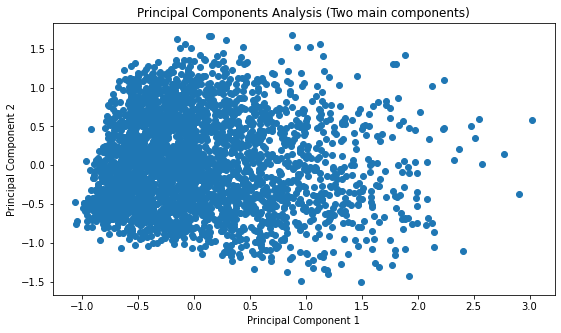

In [101]:
# We plot the two first dimensions considering 3K random observations from the xt_pca DataFrame.
rnd_idx = np.random.choice(a=xt_pca.shape[0], size=3000, replace=False)
plt.scatter(xt_pca[rnd_idx, 0], xt_pca[rnd_idx, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Components Analysis (Two main components)')

The two main components of our PCA transformed data are the two linear combinations of our original features that hold most of the variance of our data. In fact, we can note how the projection of the transformed observations onto the horizontal axis (first component) are more widely disperse, compared to the projections onto the vertical axis (second component).

## 5. Classification models

### Baseline

`LogisticRegression` or `RandomForestClassifier`

<span style="color:red">Implement your solution below</span>

We use as a baseline a Logistic Regression. The other models we will train and evaluate are Light Gradient Boosting Machine and XGBoost.

In [119]:
model_lr = linear_model.LogisticRegression()
model_lr.fit(x_train.to_numpy(), y_train)

LogisticRegression()

In [150]:
model_lgbm = lightgbm.LGBMClassifier(n_estimators=200, max_depth=3, min_child_weight=30,
                             subsample=0.8, colsample_bytree=0.8, random_state=0,
                             scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1]
                             )

model_lgbm.fit(x_train.to_numpy(), y_train)

LGBMClassifier(colsample_bytree=0.8, max_depth=3, min_child_weight=30,
               n_estimators=200, random_state=0,
               scale_pos_weight=27.658648925281472, subsample=0.8)

In [121]:
model_xgb = xgb.XGBClassifier(n_estimators=200, max_depth=3, min_child_weight=1,
                             subsample=0.8, colsample_bytree=0.8, random_state=0,
                             scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1]
                             )

model_xgb.fit(x_train, y_train)

[23:11:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=27.658648925281472, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

## 6. Evaluations

In [122]:
y_pred_lr = model_lr.predict(x_valid)
score = metrics.balanced_accuracy_score(y_valid, y_pred_lr)
print(f"Balanced accuracy score Logistic Regression: {score:.3g}")

y_pred_lgbm = model_lgbm.predict(x_valid)
score = metrics.balanced_accuracy_score(y_valid, y_pred_lgbm)
print(f"Balanced accuracy score LGBM: {score:.3g}")

y_pred_xgb = model_xgb.predict(x_valid)
score = metrics.balanced_accuracy_score(y_valid, y_pred_xgb)
print(f"Balanced accuracy score XGB: {score:.3g}")

Balanced accuracy score Logistic Regression: 0.505
Balanced accuracy score LGBM: 0.754
Balanced accuracy score XGB: 0.73


Based on the holdout validation we computed above, it looks like the LightGBM is the best model, or at least the one we should mostly focus for tuning.

### Code: Cross-validation

Use cross-validation (to get a more reliable estimate) combined with an exploration of hyperparameters (to improve results).

In [123]:
CV = 5
SCORING = "balanced_accuracy"
SCORINGS = ("balanced_accuracy", 'roc_auc')

In [124]:
lr_cv_results = model_selection.cross_validate(model_lr, x_df.to_numpy(), ys, cv=CV, scoring=SCORINGS)
lgbm_cv_results = model_selection.cross_validate(model_lgbm, x_df.to_numpy(), ys, cv=CV, scoring=SCORINGS)
xgb_cv_results = model_selection.cross_validate(model_xgb, x_df, ys, cv=CV, scoring=SCORINGS)

[23:16:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

##### Logistic Regression - cross validation

In [130]:
lr_cv_results_df = pd.DataFrame(lr_cv_results)
lr_cv_results_df

,fit_time,score_time,test_balanced_accuracy,test_roc_auc
0,2.127,0.04174,0.5041,0.7759
1,2.637,0.03954,0.5068,0.7876
2,2.166,0.0391,0.5052,0.7555
3,2.469,0.06689,0.5035,0.7828
4,2.164,0.03929,0.507,0.7689


##### Light Gradient Boosting Machine - cross validation

In [127]:
lgbm_cv_results_df = pd.DataFrame(lgbm_cv_results)
lgbm_cv_results_df

,fit_time,score_time,test_balanced_accuracy,test_roc_auc
0,0.6926,0.05598,0.7539,0.8243
1,0.6545,0.05472,0.7406,0.8254
2,0.668,0.05702,0.7401,0.8245
3,0.6495,0.0549,0.7401,0.8301
4,0.6653,0.05502,0.7442,0.8243


##### Xtreme Gradient Boosting Machine - cross validation

In [125]:
xgb_cv_results_df = pd.DataFrame(xgb_cv_results)
xgb_cv_results_df

,fit_time,score_time,test_balanced_accuracy,test_roc_auc
0,12.89,0.08388,0.7317,0.8186
1,15.4,0.0757,0.7352,0.8172
2,16.02,0.06922,0.7306,0.813
3,14.2,0.06548,0.7228,0.8218
4,15.55,0.06758,0.7289,0.8152


In [132]:
print('Mean Logistic Regression CV balanced accuracy: %.2f (+/-) %.2f' % (lr_cv_results_df['test_balanced_accuracy'].mean(), lr_cv_results_df['test_balanced_accuracy'].std()))
print('Mean LightGBM CV balanced accuracy: %.2f (+/-) %.2f' % (lgbm_cv_results_df['test_balanced_accuracy'].mean(), lgbm_cv_results_df['test_balanced_accuracy'].std()))
print('Mean XGBoost CV balanced accuracy: %.2f (+/-) %.2f' % (xgb_cv_results_df['test_balanced_accuracy'].mean(), xgb_cv_results_df['test_balanced_accuracy'].std()))

Mean Logistic Regression CV balanced accuracy: 0.51 (+/-) 0.00
Mean LightGBM CV balanced accuracy: 0.74 (+/-) 0.01
Mean XGBoost CV balanced accuracy: 0.73 (+/-) 0.00


**For each of these 2 models, from the validation data created previously** (`x_valid`,` y_valid`):

   * Measure the area under the ROC curve (AUC) using the Scikit-Learn (`roc_auc_score`) function and compare the models with their respective combination of hyperparameters giving the best result.

In [135]:
print('Mean Logistic Regression CV ROC AUC: %.2f (+/-) %.2f' % (lr_cv_results_df['test_roc_auc'].mean(), lr_cv_results_df['test_roc_auc'].std()))
print('Mean LightGBM CV ROC AUC: %.2f (+/-) %.2f' % (lgbm_cv_results_df['test_roc_auc'].mean(), lgbm_cv_results_df['test_roc_auc'].std()))

Mean Logistic Regression CV ROC AUC: 0.77 (+/-) 0.01
Mean LightGBM CV ROC AUC: 0.83 (+/-) 0.00


Considering the ROC AUC, LightGBM is stil the best model.

* **For the model and its combination of hyperparameters offering the best result**:

    * Present the confusion matrix and describe it succinctly.

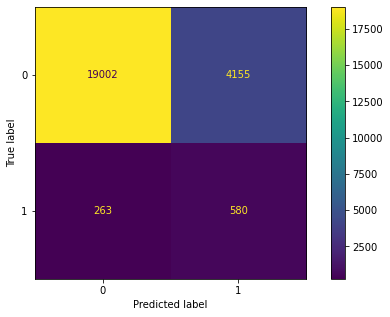

In [151]:
cm = metrics.confusion_matrix(y_valid, y_pred_lgbm, labels=model_lgbm.classes_)
cm_img = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lgbm.classes_)
cm_img.plot()

In this confussion matrix, we can see that the overall accuracy, which tells us how often is the classifier correct, is 0,816. This value is higher than the balanced accuracy due to the class imbalance we have. Let's check other metrics too:  
  
**recall**: (True Positive Rate) when it's actually yes, how often does it predict yes? = 580/(263+580) = 0.688  
**specificity**: when it's actually no, how often does it predict no? = 19002/(19002+4155) = 0.820  

For this particular problem, in which we are trying to predict who survives and who doesn't, we have that:  
1) our model identifies **68.8%** of the patients **who are really going to die.**  
2) our model indentifies **82.0%** of the patients **who are really going to survive.**

We can see that the specificity is higher, meaning that our model is better at identifying the patiens who will survive. Also, this score pushes the balanced accuracy (0.74) to a higer value, as the recall (0.688) is lower than it.

### Code: Try to improve your score

We chose to improve results by hyper parameter tunning

We used a TPE (Tree-structured Parzen Estimator) algorithm to sample the hyperparameters on every iteration. To do so we used [Optuna](https://dl.acm.org/doi/abs/10.1145/3292500.3330701) which implements that technique for hyperparameters optimization. This technique consists of a bayesian optimization using kernel fitting. It tries to sample hyperparameter candidates by enhacing on the previous iteration’s scores (i.e. incremental improvements are expected from trial to trial with this hyperparameters sampling technique).

In [113]:
def objective(trial, X, y):
    """This function is passed as an argument to the optimize function of the study object
     from the optuna package. This function indicates the parameters grid that would be explored
     for optimizing the hyperparameters. This function return the metric that should be optimized.
    """
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "subsample": trial.suggest_float("bagging_fraction", 0.5, 0.90, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "colsample_bytree": trial.suggest_float("feature_fraction", 0.4, 0.90, step=0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 150),
        "scale_pos_weight": trial.suggest_categorical('scale_pos_weight', [Counter(y)[0]/Counter(y)[1]]),
        'n_jobs': trial.suggest_categorical('n_jobs', [6])
    }
    
    model = lightgbm.LGBMClassifier(**param_grid)
    model_cv_results = model_selection.cross_validate(model, X.to_numpy(), y, cv=CV, scoring=SCORINGS)
    model_cv_results_df = pd.DataFrame(model_cv_results)
    score = model_cv_results_df['test_balanced_accuracy'].mean()
    return score

In [116]:
# A study is a collection of trials wherein each trial, we evaluate the objective function using
# a single set of hyperparameters from the given search space. A study needs a function to optimize: objective.

study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, x_df, ys)
study.optimize(func, n_trials=600)

[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.019581434252443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.019581434252443
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.019581434252443, min_split_g

[I 2021-12-30 19:29:12,523] Trial 300 finished with value: 0.7602790903108352 and parameters: {'n_estimators': 958, 'learning_rate': 0.03876946581683452, 'num_leaves': 2460, 'max_depth': 3, 'min_data_in_leaf': 2300, 'max_bin': 294, 'lambda_l1': 35, 'lambda_l2': 45, 'min_gain_to_split': 8.019581434252443, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 149, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.925310722923101, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.925310722923101
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.925310722923101, min_split_g

[I 2021-12-30 19:29:30,556] Trial 301 finished with value: 0.7610623280187605 and parameters: {'n_estimators': 984, 'learning_rate': 0.0327395962386512, 'num_leaves': 2040, 'max_depth': 3, 'min_data_in_leaf': 2500, 'max_bin': 292, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 7.925310722923101, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 146, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.091021830933002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.091021830933002
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.091021830933002, min_split_gain=

[I 2021-12-30 19:29:50,295] Trial 302 finished with value: 0.7566179767680551 and parameters: {'n_estimators': 980, 'learning_rate': 0.027751011524903668, 'num_leaves': 2020, 'max_depth': 3, 'min_data_in_leaf': 700, 'max_bin': 291, 'lambda_l1': 40, 'lambda_l2': 45, 'min_gain_to_split': 8.091021830933002, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 147, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.929892941751915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.929892941751915
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.929892941751915, min_split_g

[I 2021-12-30 19:30:09,101] Trial 303 finished with value: 0.7591171189659811 and parameters: {'n_estimators': 951, 'learning_rate': 0.03473735147222086, 'num_leaves': 1900, 'max_depth': 3, 'min_data_in_leaf': 2800, 'max_bin': 249, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 7.929892941751915, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 142, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.638956473638019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.638956473638019
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.638956473638019, min_split_g

[I 2021-12-30 19:30:28,931] Trial 304 finished with value: 0.759404475097005 and parameters: {'n_estimators': 974, 'learning_rate': 0.026486171471553292, 'num_leaves': 2780, 'max_depth': 3, 'min_data_in_leaf': 2200, 'max_bin': 289, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 7.638956473638019, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 143, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.429531264784444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.429531264784444
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.429531264784444, min_split_g

[I 2021-12-30 19:30:48,136] Trial 305 finished with value: 0.7600072427184077 and parameters: {'n_estimators': 946, 'learning_rate': 0.032929767205528114, 'num_leaves': 2060, 'max_depth': 3, 'min_data_in_leaf': 2400, 'max_bin': 293, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 8.429531264784444, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 135, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.732206531215675, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.732206531215675
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.732206531215675, min_split_g

[I 2021-12-30 19:31:07,982] Trial 306 finished with value: 0.759062565806123 and parameters: {'n_estimators': 962, 'learning_rate': 0.04018233217600555, 'num_leaves': 1820, 'max_depth': 3, 'min_data_in_leaf': 1900, 'max_bin': 296, 'lambda_l1': 40, 'lambda_l2': 45, 'min_gain_to_split': 7.732206531215675, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 150, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.462668505707152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.462668505707152
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.462668505707152, min_split_g

[I 2021-12-30 19:31:27,864] Trial 307 finished with value: 0.7582919439613766 and parameters: {'n_estimators': 983, 'learning_rate': 0.03163563853353049, 'num_leaves': 1980, 'max_depth': 3, 'min_data_in_leaf': 2700, 'max_bin': 291, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 7.462668505707152, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 145, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.5833858002509364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.5833858002509364
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.5833858002509364, min_spli

[I 2021-12-30 19:31:54,937] Trial 308 finished with value: 0.7591531924422936 and parameters: {'n_estimators': 939, 'learning_rate': 0.04208044555636736, 'num_leaves': 2080, 'max_depth': 3, 'min_data_in_leaf': 2100, 'max_bin': 286, 'lambda_l1': 40, 'lambda_l2': 45, 'min_gain_to_split': 7.5833858002509364, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 138, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.411045500763862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.411045500763862
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.411045500763862, min_split_g

[I 2021-12-30 19:32:14,656] Trial 309 finished with value: 0.758962018572853 and parameters: {'n_estimators': 965, 'learning_rate': 0.05400608059003231, 'num_leaves': 2020, 'max_depth': 3, 'min_data_in_leaf': 2400, 'max_bin': 298, 'lambda_l1': 30, 'lambda_l2': 45, 'min_gain_to_split': 8.411045500763862, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 140, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.908972862388032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.908972862388032
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.908972862388032, min_split_g

[I 2021-12-30 19:32:34,581] Trial 310 finished with value: 0.7570433152633823 and parameters: {'n_estimators': 981, 'learning_rate': 0.024861884842693128, 'num_leaves': 1900, 'max_depth': 3, 'min_data_in_leaf': 3500, 'max_bin': 294, 'lambda_l1': 40, 'lambda_l2': 45, 'min_gain_to_split': 7.908972862388032, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 135, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.7535238151576165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.7535238151576165
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.7535238151576165, min_spli

[I 2021-12-30 19:32:54,120] Trial 311 finished with value: 0.7599583772893507 and parameters: {'n_estimators': 949, 'learning_rate': 0.036769973561520695, 'num_leaves': 1820, 'max_depth': 3, 'min_data_in_leaf': 2600, 'max_bin': 296, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 6.7535238151576165, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 124, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.285887697338755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.285887697338755
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.285887697338755, min_split_g

[I 2021-12-30 19:33:12,072] Trial 312 finished with value: 0.7461047668755445 and parameters: {'n_estimators': 930, 'learning_rate': 0.04848511612206985, 'num_leaves': 2520, 'max_depth': 3, 'min_data_in_leaf': 6800, 'max_bin': 247, 'lambda_l1': 40, 'lambda_l2': 45, 'min_gain_to_split': 8.285887697338755, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 21, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.915309423290253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.915309423290253
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.915309423290253, min_split_g

[I 2021-12-30 19:33:32,977] Trial 313 finished with value: 0.7603834609724979 and parameters: {'n_estimators': 987, 'learning_rate': 0.03991322167444932, 'num_leaves': 1960, 'max_depth': 3, 'min_data_in_leaf': 1800, 'max_bin': 292, 'lambda_l1': 35, 'lambda_l2': 50, 'min_gain_to_split': 8.915309423290253, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 147, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.45308504267337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.45308504267337
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.45308504267337, min_split_gain

[I 2021-12-30 19:33:55,152] Trial 314 finished with value: 0.7578344714858 and parameters: {'n_estimators': 963, 'learning_rate': 0.030046589726821855, 'num_leaves': 2100, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 300, 'lambda_l1': 40, 'lambda_l2': 50, 'min_gain_to_split': 8.45308504267337, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 144, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.933273957225495, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.933273957225495
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.933273957225495, min_split_g

[I 2021-12-30 19:34:14,406] Trial 315 finished with value: 0.7510525349478614 and parameters: {'n_estimators': 948, 'learning_rate': 0.0703329481701485, 'num_leaves': 1780, 'max_depth': 3, 'min_data_in_leaf': 3100, 'max_bin': 298, 'lambda_l1': 30, 'lambda_l2': 60, 'min_gain_to_split': 8.933273957225495, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 13, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.4436029209514265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.4436029209514265
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.4436029209514265, min_spli

[I 2021-12-30 19:34:36,958] Trial 316 finished with value: 0.7411560363484919 and parameters: {'n_estimators': 1000, 'learning_rate': 0.061416651226945854, 'num_leaves': 1860, 'max_depth': 8, 'min_data_in_leaf': 2000, 'max_bin': 251, 'lambda_l1': 40, 'lambda_l2': 45, 'min_gain_to_split': 7.4436029209514265, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 10, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.0351002850333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.0351002850333
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.0351002850333, min_split_gain=0.0 wi

[I 2021-12-30 19:34:57,207] Trial 317 finished with value: 0.7585592140540293 and parameters: {'n_estimators': 970, 'learning_rate': 0.04819816161288129, 'num_leaves': 2040, 'max_depth': 3, 'min_data_in_leaf': 900, 'max_bin': 215, 'lambda_l1': 35, 'lambda_l2': 50, 'min_gain_to_split': 8.0351002850333, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 130, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.999469807846625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.999469807846625
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.999469807846625, min_split_g

[I 2021-12-30 19:35:20,061] Trial 318 finished with value: 0.7621327147700011 and parameters: {'n_estimators': 931, 'learning_rate': 0.03540860325877075, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 294, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 3.999469807846625, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 271 with value: 0.7625114668421316.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.469985708915006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.469985708915006
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.469985708915006, min_split_g

[I 2021-12-30 19:35:42,945] Trial 319 finished with value: 0.7627028050833077 and parameters: {'n_estimators': 927, 'learning_rate': 0.03341083070793961, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 288, 'lambda_l1': 40, 'lambda_l2': 35, 'min_gain_to_split': 2.469985708915006, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 16, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.7223740876961204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7223740876961204
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.7223740876961204, min_spli

[I 2021-12-30 19:36:03,689] Trial 320 finished with value: 0.7570862365170121 and parameters: {'n_estimators': 921, 'learning_rate': 0.026738189418834872, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 287, 'lambda_l1': 40, 'lambda_l2': 35, 'min_gain_to_split': 3.7223740876961204, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 17, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.365551993912066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.365551993912066
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.365551993912066, min_split_g

[I 2021-12-30 19:36:26,432] Trial 321 finished with value: 0.7601697786122845 and parameters: {'n_estimators': 929, 'learning_rate': 0.022430757962394618, 'num_leaves': 2800, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 290, 'lambda_l1': 40, 'lambda_l2': 35, 'min_gain_to_split': 2.365551993912066, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 43, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9737028946110966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9737028946110966
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9737028946110966, min_spli

[I 2021-12-30 19:36:48,431] Trial 322 finished with value: 0.7588774837842086 and parameters: {'n_estimators': 912, 'learning_rate': 0.03266087364903926, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 285, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 3.9737028946110966, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.835243313418063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.835243313418063
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.835243313418063, min_split_g

[I 2021-12-30 19:37:09,857] Trial 323 finished with value: 0.7601053463414725 and parameters: {'n_estimators': 939, 'learning_rate': 0.03506888208359376, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 282, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 5.835243313418063, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1125747582128755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1125747582128755
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1125747582128755, min_spli

[I 2021-12-30 19:37:30,417] Trial 324 finished with value: 0.7587258801937125 and parameters: {'n_estimators': 898, 'learning_rate': 0.03722447214863401, 'num_leaves': 2680, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 292, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 1.1125747582128755, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 33, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5733521340261962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5733521340261962
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5733521340261962, min_spli

[I 2021-12-30 19:37:52,882] Trial 325 finished with value: 0.7600569180996516 and parameters: {'n_estimators': 937, 'learning_rate': 0.030918998451516598, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 289, 'lambda_l1': 40, 'lambda_l2': 30, 'min_gain_to_split': 1.5733521340261962, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_weight': 26, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.252733638748856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.252733638748856
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.252733638748856, min_split_g

[I 2021-12-30 19:38:18,562] Trial 326 finished with value: 0.7583358177338922 and parameters: {'n_estimators': 926, 'learning_rate': 0.03962087922506377, 'num_leaves': 2680, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 288, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 2.252733638748856, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 80, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.563966652313455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.563966652313455
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.563966652313455, min_split_g

[I 2021-12-30 19:38:39,507] Trial 327 finished with value: 0.7265803401644166 and parameters: {'n_estimators': 951, 'learning_rate': 0.220453772299889, 'num_leaves': 2100, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 294, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 5.563966652313455, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 20, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9721519636919886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9721519636919886
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9721519636919886, min_spli

[I 2021-12-30 19:38:59,543] Trial 328 finished with value: 0.7544451836565551 and parameters: {'n_estimators': 910, 'learning_rate': 0.0184012125892349, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 269, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 2.9721519636919886, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 17, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.03675444705492925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03675444705492925
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.03675444705492925, min_s

[I 2021-12-30 19:39:23,078] Trial 329 finished with value: 0.7612209604561234 and parameters: {'n_estimators': 936, 'learning_rate': 0.025901312605030702, 'num_leaves': 2960, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 291, 'lambda_l1': 35, 'lambda_l2': 45, 'min_gain_to_split': 0.03675444705492925, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.35393841236936135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35393841236936135
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.35393841236936135, min_s

[I 2021-12-30 19:39:44,970] Trial 330 finished with value: 0.7591039157454356 and parameters: {'n_estimators': 875, 'learning_rate': 0.02380702505382296, 'num_leaves': 3000, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 290, 'lambda_l1': 30, 'lambda_l2': 45, 'min_gain_to_split': 0.35393841236936135, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.131641139128603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.131641139128603
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.131641139128603, min_split_g

[I 2021-12-30 19:40:07,830] Trial 331 finished with value: 0.7580342529864005 and parameters: {'n_estimators': 925, 'learning_rate': 0.02713724062726065, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 288, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 6.131641139128603, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 73, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.355810857412241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.355810857412241
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.355810857412241, min_split_g

[I 2021-12-30 19:40:29,767] Trial 332 finished with value: 0.7570963399272663 and parameters: {'n_estimators': 894, 'learning_rate': 0.01792569477735087, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 291, 'lambda_l1': 35, 'lambda_l2': 45, 'min_gain_to_split': 4.355810857412241, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 74, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.695588061697909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.695588061697909
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.695588061697909, min_split_g

[I 2021-12-30 19:40:52,814] Trial 333 finished with value: 0.7616531777225167 and parameters: {'n_estimators': 939, 'learning_rate': 0.03325713420645777, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 246, 'lambda_l1': 30, 'lambda_l2': 45, 'min_gain_to_split': 4.695588061697909, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.565984255721468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.565984255721468
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.565984255721468, min_split_g

[I 2021-12-30 19:41:14,635] Trial 334 finished with value: 0.7621369918098866 and parameters: {'n_estimators': 915, 'learning_rate': 0.03567150387621569, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 247, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 4.565984255721468, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.786104531076868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.786104531076868
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.786104531076868, min_split_g

[I 2021-12-30 19:41:36,460] Trial 335 finished with value: 0.7578243692538142 and parameters: {'n_estimators': 908, 'learning_rate': 0.02411679674348994, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 3300, 'max_bin': 249, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 4.786104531076868, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.652489536762699, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.652489536762699
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.652489536762699, min_split_g

[I 2021-12-30 19:41:58,075] Trial 336 finished with value: 0.7594926706405696 and parameters: {'n_estimators': 916, 'learning_rate': 0.03414155872378481, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 246, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 4.652489536762699, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 30, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.996289564221602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.996289564221602
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.996289564221602, min_split_g

[I 2021-12-30 19:42:21,421] Trial 337 finished with value: 0.7593536141835141 and parameters: {'n_estimators': 883, 'learning_rate': 0.027855691058780517, 'num_leaves': 2860, 'max_depth': 5, 'min_data_in_leaf': 3200, 'max_bin': 253, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 2.996289564221602, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.201066634780544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.201066634780544
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.201066634780544, min_split_g

[I 2021-12-30 19:42:43,006] Trial 338 finished with value: 0.761055579271926 and parameters: {'n_estimators': 937, 'learning_rate': 0.037443704393846505, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 246, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 4.201066634780544, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 319 with value: 0.7627028050833077.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.399142098375606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.399142098375606
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.399142098375606, min_split_g

[I 2021-12-30 19:43:04,794] Trial 339 finished with value: 0.7628784821524556 and parameters: {'n_estimators': 932, 'learning_rate': 0.03336628300083727, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 247, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 3.399142098375606, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.309181341455927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.309181341455927
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.309181341455927, min_split_g

[I 2021-12-30 19:43:26,467] Trial 340 finished with value: 0.7575773681603997 and parameters: {'n_estimators': 927, 'learning_rate': 0.021422821843241777, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 4.309181341455927, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 70, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.476697210544626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.476697210544626
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.476697210544626, min_split_g

[I 2021-12-30 19:43:48,036] Trial 341 finished with value: 0.7586264316938139 and parameters: {'n_estimators': 904, 'learning_rate': 0.032346946793861, 'num_leaves': 2640, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 248, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 3.476697210544626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.398868931813886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.398868931813886
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.398868931813886, min_split_g

[I 2021-12-30 19:44:08,657] Trial 342 finished with value: 0.7589638321817516 and parameters: {'n_estimators': 893, 'learning_rate': 0.037715247791423316, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 3500, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 4.398868931813886, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.332819803905906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.332819803905906
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.332819803905906, min_split_g

[I 2021-12-30 19:44:30,046] Trial 343 finished with value: 0.7624031986291235 and parameters: {'n_estimators': 932, 'learning_rate': 0.026507207532914644, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 249, 'lambda_l1': 30, 'lambda_l2': 25, 'min_gain_to_split': 3.332819803905906, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3632155726434774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3632155726434774
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3632155726434774, min_spli

[I 2021-12-30 19:44:50,126] Trial 344 finished with value: 0.7512206218247185 and parameters: {'n_estimators': 864, 'learning_rate': 0.013846229951215736, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 249, 'lambda_l1': 30, 'lambda_l2': 25, 'min_gain_to_split': 3.3632155726434774, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 73, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.903232523315067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.903232523315067
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.903232523315067, min_split_g

[I 2021-12-30 19:45:10,992] Trial 345 finished with value: 0.7583275952909522 and parameters: {'n_estimators': 915, 'learning_rate': 0.024102400239848384, 'num_leaves': 2620, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 252, 'lambda_l1': 30, 'lambda_l2': 25, 'min_gain_to_split': 3.903232523315067, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 78, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.291784725717388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.291784725717388
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.291784725717388, min_split_g

[I 2021-12-30 19:45:31,921] Trial 346 finished with value: 0.7594071175269966 and parameters: {'n_estimators': 934, 'learning_rate': 0.02828639129574557, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 247, 'lambda_l1': 25, 'lambda_l2': 25, 'min_gain_to_split': 3.291784725717388, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 70, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.924463832686226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.924463832686226
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.924463832686226, min_split_g

[I 2021-12-30 19:45:53,317] Trial 347 finished with value: 0.7536858994716045 and parameters: {'n_estimators': 903, 'learning_rate': 0.020183568196460576, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 3200, 'max_bin': 250, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 4.924463832686226, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.0098513181534905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0098513181534905
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.0098513181534905, min_spli

[I 2021-12-30 19:46:14,725] Trial 348 finished with value: 0.7596676161221196 and parameters: {'n_estimators': 935, 'learning_rate': 0.03216792769242724, 'num_leaves': 2960, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 242, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 4.0098513181534905, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.5402402028185485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5402402028185485
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.5402402028185485, min_spli

[I 2021-12-30 19:46:35,896] Trial 349 finished with value: 0.7580763759727652 and parameters: {'n_estimators': 919, 'learning_rate': 0.02720232893999339, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 245, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 4.5402402028185485, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.778542428180376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.778542428180376
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.778542428180376, min_split_g

[I 2021-12-30 19:46:56,509] Trial 350 finished with value: 0.761986176726389 and parameters: {'n_estimators': 881, 'learning_rate': 0.03512962792011816, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 245, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 3.778542428180376, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 66, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.6729950818104817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6729950818104817
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.6729950818104817, min_spli

[I 2021-12-30 19:47:16,963] Trial 351 finished with value: 0.735986866519682 and parameters: {'n_estimators': 881, 'learning_rate': 0.01635451834142153, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 8100, 'max_bin': 248, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 3.6729950818104817, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.224645860346197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.224645860346197
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.224645860346197, min_split_g

[I 2021-12-30 19:47:40,692] Trial 352 finished with value: 0.7622338142257993 and parameters: {'n_estimators': 900, 'learning_rate': 0.03449187730420287, 'num_leaves': 2880, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 245, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 3.224645860346197, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 77, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9965886316676387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9965886316676387
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9965886316676387, min_spli

[I 2021-12-30 19:48:01,261] Trial 353 finished with value: 0.7576603568487223 and parameters: {'n_estimators': 875, 'learning_rate': 0.031377899423787436, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 3300, 'max_bin': 244, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 2.9965886316676387, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6193972975329567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6193972975329567
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6193972975329567, min_spli

[I 2021-12-30 19:48:23,511] Trial 354 finished with value: 0.755014279154449 and parameters: {'n_estimators': 859, 'learning_rate': 0.023560294675839335, 'num_leaves': 2860, 'max_depth': 5, 'min_data_in_leaf': 3800, 'max_bin': 240, 'lambda_l1': 30, 'lambda_l2': 25, 'min_gain_to_split': 2.6193972975329567, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 77, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.062620230680204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.062620230680204
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.062620230680204, min_split_g

[I 2021-12-30 19:48:47,804] Trial 355 finished with value: 0.7594295811760464 and parameters: {'n_estimators': 897, 'learning_rate': 0.035128628981116614, 'num_leaves': 2880, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 4.062620230680204, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 84, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.192752832700958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.192752832700958
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.192752832700958, min_split_g

[I 2021-12-30 19:49:09,049] Trial 356 finished with value: 0.758483933714864 and parameters: {'n_estimators': 896, 'learning_rate': 0.027591161981884015, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 242, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 3.192752832700958, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 70, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.606607713032381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.606607713032381
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.606607713032381, min_split_g

[I 2021-12-30 19:49:30,414] Trial 357 finished with value: 0.76050447928604 and parameters: {'n_estimators': 884, 'learning_rate': 0.03581236042507763, 'num_leaves': 3000, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 251, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 3.606607713032381, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.7482644677114663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7482644677114663
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.7482644677114663, min_spli

[I 2021-12-30 19:49:51,163] Trial 358 finished with value: 0.7543479910867045 and parameters: {'n_estimators': 917, 'learning_rate': 0.030589361037938433, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 3600, 'max_bin': 244, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 3.7482644677114663, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.133810772005699, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.133810772005699
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.133810772005699, min_split_g

[I 2021-12-30 19:50:13,271] Trial 359 finished with value: 0.7570603750486482 and parameters: {'n_estimators': 909, 'learning_rate': 0.020146711045629373, 'num_leaves': 2960, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 248, 'lambda_l1': 30, 'lambda_l2': 25, 'min_gain_to_split': 5.133810772005699, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 76, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.135838008833959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.135838008833959
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.135838008833959, min_split_g

[I 2021-12-30 19:50:34,014] Trial 360 finished with value: 0.7599811854607175 and parameters: {'n_estimators': 849, 'learning_rate': 0.03664608254707734, 'num_leaves': 2800, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 245, 'lambda_l1': 30, 'lambda_l2': 25, 'min_gain_to_split': 4.135838008833959, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.454986919584808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.454986919584808
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.454986919584808, min_split_g

[I 2021-12-30 19:50:56,028] Trial 361 finished with value: 0.7520072041293312 and parameters: {'n_estimators': 935, 'learning_rate': 0.02522474762774477, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 4500, 'max_bin': 255, 'lambda_l1': 20, 'lambda_l2': 20, 'min_gain_to_split': 3.454986919584808, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.206278773386201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.206278773386201
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.206278773386201, min_split_g

[I 2021-12-30 19:51:20,223] Trial 362 finished with value: 0.7580619071055608 and parameters: {'n_estimators': 917, 'learning_rate': 0.03859790740631912, 'num_leaves': 2660, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 247, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 4.206278773386201, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6791171067474475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6791171067474475
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6791171067474475, min_spli

[I 2021-12-30 19:51:33,641] Trial 363 finished with value: 0.7572078735663862 and parameters: {'n_estimators': 499, 'learning_rate': 0.03204589566375506, 'num_leaves': 2600, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 250, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 2.6791171067474475, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8249594162945124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8249594162945124
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8249594162945124, min_spli

[I 2021-12-30 19:51:55,911] Trial 364 finished with value: 0.762738873939484 and parameters: {'n_estimators': 938, 'learning_rate': 0.03921034847283373, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 248, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 3.8249594162945124, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 53, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 339 with value: 0.7628784821524556.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2637046158660652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2637046158660652
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2637046158660652, min_spli

[I 2021-12-30 19:52:21,546] Trial 365 finished with value: 0.764298852204776 and parameters: {'n_estimators': 942, 'learning_rate': 0.030603271976480054, 'num_leaves': 2540, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.2637046158660652, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.308600115423034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.308600115423034
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.308600115423034, min_split_g

[I 2021-12-30 19:52:43,874] Trial 366 finished with value: 0.7608775306245067 and parameters: {'n_estimators': 901, 'learning_rate': 0.028169480347560547, 'num_leaves': 2700, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 253, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 3.308600115423034, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.7517759150377294, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7517759150377294
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.7517759150377294, min_spli

[I 2021-12-30 19:53:08,844] Trial 367 finished with value: 0.7550190432913904 and parameters: {'n_estimators': 923, 'learning_rate': 0.040243878041668256, 'num_leaves': 2480, 'max_depth': 5, 'min_data_in_leaf': 2300, 'max_bin': 250, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 3.7517759150377294, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5848174997219502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5848174997219502
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5848174997219502, min_spli

[I 2021-12-30 19:53:33,322] Trial 368 finished with value: 0.7626120581378296 and parameters: {'n_estimators': 888, 'learning_rate': 0.023486127123392916, 'num_leaves': 2520, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 250, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 1.5848174997219502, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6756664980681135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6756664980681135
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6756664980681135, min_spli

[I 2021-12-30 19:53:57,135] Trial 369 finished with value: 0.7524736101011852 and parameters: {'n_estimators': 858, 'learning_rate': 0.010441186276666261, 'num_leaves': 2520, 'max_depth': 6, 'min_data_in_leaf': 2500, 'max_bin': 252, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 1.6756664980681135, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1629235034239374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1629235034239374
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1629235034239374, min_spli

[I 2021-12-30 19:54:13,683] Trial 370 finished with value: 0.7509924412484323 and parameters: {'n_estimators': 584, 'learning_rate': 0.014810746821842882, 'num_leaves': 2600, 'max_depth': 5, 'min_data_in_leaf': 2600, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 25, 'min_gain_to_split': 1.1629235034239374, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 45, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6018003608702074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6018003608702074
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6018003608702074, min_spli

[I 2021-12-30 19:54:46,461] Trial 371 finished with value: 0.7591724942686855 and parameters: {'n_estimators': 872, 'learning_rate': 0.01946123286463976, 'num_leaves': 2840, 'max_depth': 6, 'min_data_in_leaf': 2400, 'max_bin': 249, 'lambda_l1': 20, 'lambda_l2': 25, 'min_gain_to_split': 2.6018003608702074, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'min_child_weight': 54, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.0112344969611048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0112344969611048
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.0112344969611048, min_spli

[I 2021-12-30 19:55:10,465] Trial 372 finished with value: 0.7610378165077614 and parameters: {'n_estimators': 897, 'learning_rate': 0.024465262584584584, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 2600, 'max_bin': 248, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 0.0112344969611048, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0687467902791177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0687467902791177
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0687467902791177, min_spli

[I 2021-12-30 19:55:32,237] Trial 373 finished with value: 0.7593089975721827 and parameters: {'n_estimators': 887, 'learning_rate': 0.02099944738108998, 'num_leaves': 2940, 'max_depth': 5, 'min_data_in_leaf': 3000, 'max_bin': 243, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 2.0687467902791177, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 80, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7950147967798387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7950147967798387
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7950147967798387, min_spli

[I 2021-12-30 19:55:57,541] Trial 374 finished with value: 0.7609001221062222 and parameters: {'n_estimators': 944, 'learning_rate': 0.028302259483810915, 'num_leaves': 2880, 'max_depth': 5, 'min_data_in_leaf': 2300, 'max_bin': 245, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 1.7950147967798387, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 52, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4036419800241893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4036419800241893
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4036419800241893, min_spli

[I 2021-12-30 19:56:21,360] Trial 375 finished with value: 0.7611269996970107 and parameters: {'n_estimators': 885, 'learning_rate': 0.032941054346387826, 'num_leaves': 2560, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 252, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 1.4036419800241893, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9718568253795248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9718568253795248
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9718568253795248, min_spli

[I 2021-12-30 19:56:44,330] Trial 376 finished with value: 0.756206237986093 and parameters: {'n_estimators': 872, 'learning_rate': 0.01782666198176262, 'num_leaves': 2540, 'max_depth': 5, 'min_data_in_leaf': 3300, 'max_bin': 254, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 0.9718568253795248, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8950355632216982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8950355632216982
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8950355632216982, min_spli

[I 2021-12-30 19:57:09,032] Trial 377 finished with value: 0.7316241885708294 and parameters: {'n_estimators': 850, 'learning_rate': 0.0917080788632358, 'num_leaves': 2440, 'max_depth': 6, 'min_data_in_leaf': 2800, 'max_bin': 251, 'lambda_l1': 10, 'lambda_l2': 35, 'min_gain_to_split': 0.8950355632216982, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 48, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2487407369318042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2487407369318042
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2487407369318042, min_spli

[I 2021-12-30 19:57:31,842] Trial 378 finished with value: 0.7576552682651518 and parameters: {'n_estimators': 884, 'learning_rate': 0.025117611804419855, 'num_leaves': 2680, 'max_depth': 5, 'min_data_in_leaf': 3100, 'max_bin': 203, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 1.2487407369318042, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.135918344811958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.135918344811958
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.135918344811958, min_split_g

[I 2021-12-30 19:57:56,834] Trial 379 finished with value: 0.7611080299883188 and parameters: {'n_estimators': 906, 'learning_rate': 0.03260849921421055, 'num_leaves': 2560, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 257, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 2.135918344811958, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1127989979752457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1127989979752457
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1127989979752457, min_split_ga

[I 2021-12-30 19:58:21,079] Trial 380 finished with value: 0.7625420312597082 and parameters: {'n_estimators': 902, 'learning_rate': 0.030066418730981023, 'num_leaves': 2580, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 255, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 2.1127989979752457, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5243453225113575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5243453225113575
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5243453225113575, min_split_ga

[I 2021-12-30 19:58:43,277] Trial 381 finished with value: 0.7609259793596403 and parameters: {'n_estimators': 868, 'learning_rate': 0.024348390814701127, 'num_leaves': 2580, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 252, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 1.5243453225113575, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 54, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.356255658120801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.356255658120801
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.356255658120801, min_split_gain=

[I 2021-12-30 19:59:10,781] Trial 382 finished with value: 0.7553642301332271 and parameters: {'n_estimators': 881, 'learning_rate': 0.03036425148965228, 'num_leaves': 2480, 'max_depth': 9, 'min_data_in_leaf': 3100, 'max_bin': 224, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 2.356255658120801, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.49300431262860933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49300431262860933
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.49300431262860933, min_s

[I 2021-12-30 19:59:35,571] Trial 383 finished with value: 0.7578307293972522 and parameters: {'n_estimators': 909, 'learning_rate': 0.017283173322665192, 'num_leaves': 2600, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 255, 'lambda_l1': 10, 'lambda_l2': 40, 'min_gain_to_split': 0.49300431262860933, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 52, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4433450483848322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4433450483848322
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4433450483848322, min_split_ga

[I 2021-12-30 19:59:44,062] Trial 384 finished with value: 0.7484135447225128 and parameters: {'n_estimators': 264, 'learning_rate': 0.02812267009595507, 'num_leaves': 2660, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 250, 'lambda_l1': 0, 'lambda_l2': 35, 'min_gain_to_split': 1.4433450483848322, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0431072275294113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0431072275294113
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0431072275294113, min_split_ga

[I 2021-12-30 20:00:08,506] Trial 385 finished with value: 0.7581533419832214 and parameters: {'n_estimators': 890, 'learning_rate': 0.03579103915992468, 'num_leaves': 2820, 'max_depth': 5, 'min_data_in_leaf': 2100, 'max_bin': 248, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 2.0431072275294113, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8257789292751219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8257789292751219
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8257789292751219, min_spli

[I 2021-12-30 20:00:27,693] Trial 386 finished with value: 0.7252420813234532 and parameters: {'n_estimators': 820, 'learning_rate': 0.25249787032225285, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 7400, 'max_bin': 247, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 1.8257789292751219, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.946003378712298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.946003378712298
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.946003378712298, min_split_g

[I 2021-12-30 20:00:50,600] Trial 387 finished with value: 0.7586330710245335 and parameters: {'n_estimators': 839, 'learning_rate': 0.021198099675715357, 'num_leaves': 2380, 'max_depth': 5, 'min_data_in_leaf': 2600, 'max_bin': 253, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 2.946003378712298, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.166130298407472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.166130298407472
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.166130298407472, min_split_gain=

[I 2021-12-30 20:01:16,681] Trial 388 finished with value: 0.7578104202521055 and parameters: {'n_estimators': 919, 'learning_rate': 0.033407676920188034, 'num_leaves': 2520, 'max_depth': 6, 'min_data_in_leaf': 2900, 'max_bin': 251, 'lambda_l1': 5, 'lambda_l2': 30, 'min_gain_to_split': 3.166130298407472, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 50, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8997392773344322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8997392773344322
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8997392773344322, min_spli

[I 2021-12-30 20:01:41,218] Trial 389 finished with value: 0.7565972312211848 and parameters: {'n_estimators': 906, 'learning_rate': 0.04115119490011971, 'num_leaves': 2620, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 245, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 1.8997392773344322, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4138759596134136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4138759596134136
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4138759596134136, min_spli

[I 2021-12-30 20:02:05,638] Trial 390 finished with value: 0.7604593319178428 and parameters: {'n_estimators': 897, 'learning_rate': 0.02738165047074574, 'num_leaves': 2780, 'max_depth': 5, 'min_data_in_leaf': 2300, 'max_bin': 243, 'lambda_l1': 10, 'lambda_l2': 30, 'min_gain_to_split': 1.4138759596134136, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.45424869551494, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.45424869551494
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.45424869551494, min_split_gain

[I 2021-12-30 20:02:28,525] Trial 391 finished with value: 0.7607516190848387 and parameters: {'n_estimators': 924, 'learning_rate': 0.03363516177069255, 'num_leaves': 2700, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 260, 'lambda_l1': 30, 'lambda_l2': 20, 'min_gain_to_split': 2.45424869551494, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5021021799346674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5021021799346674
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5021021799346674, min_spli

[I 2021-12-30 20:02:52,324] Trial 392 finished with value: 0.7551263556771 and parameters: {'n_estimators': 884, 'learning_rate': 0.040336215426207994, 'num_leaves': 3000, 'max_depth': 5, 'min_data_in_leaf': 2100, 'max_bin': 241, 'lambda_l1': 35, 'lambda_l2': 25, 'min_gain_to_split': 3.5021021799346674, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7337573693574381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7337573693574381
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7337573693574381, min_spli

[I 2021-12-30 20:03:13,657] Trial 393 finished with value: 0.7582866918921297 and parameters: {'n_estimators': 937, 'learning_rate': 0.029196678606810744, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 248, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 0.7337573693574381, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8037457173820304, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8037457173820304
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8037457173820304, min_spli

[I 2021-12-30 20:03:35,633] Trial 394 finished with value: 0.7612311053916484 and parameters: {'n_estimators': 918, 'learning_rate': 0.021690866596519753, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 247, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 3.8037457173820304, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 66, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9306400286240066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9306400286240066
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9306400286240066, min_spli

[I 2021-12-30 20:03:58,143] Trial 395 finished with value: 0.7558418491400767 and parameters: {'n_estimators': 915, 'learning_rate': 0.013526618132153247, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 2000, 'max_bin': 246, 'lambda_l1': 30, 'lambda_l2': 45, 'min_gain_to_split': 3.9306400286240066, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 74, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.6310178540040434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6310178540040434
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.6310178540040434, min_spli

[I 2021-12-30 20:04:20,537] Trial 396 finished with value: 0.7575733636891485 and parameters: {'n_estimators': 933, 'learning_rate': 0.019005283119503114, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 243, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 3.6310178540040434, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 38, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.616495255917032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.616495255917032
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.616495255917032, min_split_g

[I 2021-12-30 20:04:43,629] Trial 397 finished with value: 0.7581067156182122 and parameters: {'n_estimators': 946, 'learning_rate': 0.02076453253961241, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 248, 'lambda_l1': 35, 'lambda_l2': 25, 'min_gain_to_split': 4.616495255917032, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 66, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7756213593398558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7756213593398558
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7756213593398558, min_spli

[I 2021-12-30 20:05:06,083] Trial 398 finished with value: 0.7537369755161569 and parameters: {'n_estimators': 926, 'learning_rate': 0.013775892863268772, 'num_leaves': 2700, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 245, 'lambda_l1': 30, 'lambda_l2': 45, 'min_gain_to_split': 2.7756213593398558, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 66, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.242948042449449, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.242948042449449
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.242948042449449, min_split_g

[I 2021-12-30 20:05:28,114] Trial 399 finished with value: 0.7597873708781996 and parameters: {'n_estimators': 908, 'learning_rate': 0.02437677870186577, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 250, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 3.242948042449449, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.81148542736582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.81148542736582
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.81148542736582, min_split_gain

[I 2021-12-30 20:05:51,607] Trial 400 finished with value: 0.7603198281739105 and parameters: {'n_estimators': 947, 'learning_rate': 0.04021654441119127, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 1900, 'max_bin': 239, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 3.81148542736582, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4581804581663316, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4581804581663316
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4581804581663316, min_spli

[I 2021-12-30 20:06:14,139] Trial 401 finished with value: 0.7614514706721799 and parameters: {'n_estimators': 923, 'learning_rate': 0.02475000428002854, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 246, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 3.4581804581663316, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.424991942420448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.424991942420448
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.424991942420448, min_split_g

[I 2021-12-30 20:06:36,954] Trial 402 finished with value: 0.7508635737297304 and parameters: {'n_estimators': 915, 'learning_rate': 0.010725415953917225, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 247, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 3.424991942420448, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.021368009240322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.021368009240322
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.021368009240322, min_split_g

[I 2021-12-30 20:06:58,926] Trial 403 finished with value: 0.7608075967711521 and parameters: {'n_estimators': 897, 'learning_rate': 0.025151748008861552, 'num_leaves': 2660, 'max_depth': 4, 'min_data_in_leaf': 2100, 'max_bin': 245, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 3.021368009240322, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9492535405977276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9492535405977276
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9492535405977276, min_spli

[I 2021-12-30 20:07:21,215] Trial 404 finished with value: 0.7542823266635866 and parameters: {'n_estimators': 930, 'learning_rate': 0.020316346497004596, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 3300, 'max_bin': 242, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 3.9492535405977276, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.784623035642211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.784623035642211
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.784623035642211, min_split_g

[I 2021-12-30 20:07:38,296] Trial 405 finished with value: 0.7603093054525027 and parameters: {'n_estimators': 658, 'learning_rate': 0.026899642098956678, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.784623035642211, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 75, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.658157087806976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.658157087806976
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.658157087806976, min_split_g

[I 2021-12-30 20:08:00,661] Trial 406 finished with value: 0.7598937324432857 and parameters: {'n_estimators': 912, 'learning_rate': 0.022318879509183487, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 247, 'lambda_l1': 30, 'lambda_l2': 45, 'min_gain_to_split': 3.658157087806976, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4066794421265434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4066794421265434
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4066794421265434, min_spli

[I 2021-12-30 20:08:24,037] Trial 407 finished with value: 0.7547616880614267 and parameters: {'n_estimators': 928, 'learning_rate': 0.016213772589506095, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 1800, 'max_bin': 244, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 3.4066794421265434, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.379332212194662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.379332212194662
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.379332212194662, min_split_g

[I 2021-12-30 20:08:51,748] Trial 408 finished with value: 0.7619944351884047 and parameters: {'n_estimators': 897, 'learning_rate': 0.030875972843973244, 'num_leaves': 2720, 'max_depth': 7, 'min_data_in_leaf': 2800, 'max_bin': 247, 'lambda_l1': 35, 'lambda_l2': 45, 'min_gain_to_split': 4.379332212194662, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.5223256186383125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5223256186383125
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.5223256186383125, min_spli

[I 2021-12-30 20:09:13,275] Trial 409 finished with value: 0.7276809370897754 and parameters: {'n_estimators': 888, 'learning_rate': 0.14277440778693695, 'num_leaves': 2660, 'max_depth': 8, 'min_data_in_leaf': 3100, 'max_bin': 246, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 4.5223256186383125, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.962500884170256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.962500884170256
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.962500884170256, min_split_g

[I 2021-12-30 20:09:32,838] Trial 410 finished with value: 0.7605999098327781 and parameters: {'n_estimators': 862, 'learning_rate': 0.036147169397111246, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 249, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 4.962500884170256, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.30738003443158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.30738003443158
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.30738003443158, min_split_gain

[I 2021-12-30 20:09:57,134] Trial 411 finished with value: 0.7568893887914359 and parameters: {'n_estimators': 870, 'learning_rate': 0.03204141300764753, 'num_leaves': 2760, 'max_depth': 6, 'min_data_in_leaf': 3000, 'max_bin': 243, 'lambda_l1': 90, 'lambda_l2': 45, 'min_gain_to_split': 4.30738003443158, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.114151870651864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.114151870651864
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.114151870651864, min_split_g

[I 2021-12-30 20:10:18,811] Trial 412 finished with value: 0.7596107807262401 and parameters: {'n_estimators': 897, 'learning_rate': 0.0316613751256511, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 247, 'lambda_l1': 35, 'lambda_l2': 20, 'min_gain_to_split': 4.114151870651864, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 54, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9257459630841094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9257459630841094
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9257459630841094, min_spli

[I 2021-12-30 20:10:53,629] Trial 413 finished with value: 0.7538249497374995 and parameters: {'n_estimators': 907, 'learning_rate': 0.03789574823652549, 'num_leaves': 2660, 'max_depth': 10, 'min_data_in_leaf': 3400, 'max_bin': 250, 'lambda_l1': 25, 'lambda_l2': 25, 'min_gain_to_split': 3.9257459630841094, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.4107667516155855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4107667516155855
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.4107667516155855, min_spli

[I 2021-12-30 20:11:15,448] Trial 414 finished with value: 0.7618539586996139 and parameters: {'n_estimators': 919, 'learning_rate': 0.029476984400798704, 'num_leaves': 2700, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 241, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 4.4107667516155855, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.7044437711409754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7044437711409754
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.7044437711409754, min_spli

[I 2021-12-30 20:11:37,900] Trial 415 finished with value: 0.7595737208029847 and parameters: {'n_estimators': 897, 'learning_rate': 0.02761697813251556, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 1900, 'max_bin': 240, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 4.7044437711409754, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.4902644503687394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.4902644503687394
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.4902644503687394, min_spli

[I 2021-12-30 20:11:59,242] Trial 416 finished with value: 0.7569856099815337 and parameters: {'n_estimators': 870, 'learning_rate': 0.02140449878526187, 'num_leaves': 2620, 'max_depth': 4, 'min_data_in_leaf': 2100, 'max_bin': 244, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 5.4902644503687394, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.397342273944122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.397342273944122
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.397342273944122, min_split_g

[I 2021-12-30 20:12:21,073] Trial 417 finished with value: 0.7615099897675306 and parameters: {'n_estimators': 916, 'learning_rate': 0.029452579970321014, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 238, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 4.397342273944122, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.565822614185334, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.565822614185334
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.565822614185334, min_split_g

[I 2021-12-30 20:12:50,477] Trial 418 finished with value: 0.7509382474988544 and parameters: {'n_estimators': 886, 'learning_rate': 0.031481053683979576, 'num_leaves': 2820, 'max_depth': 7, 'min_data_in_leaf': 1700, 'max_bin': 241, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 4.565822614185334, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.0655952472402515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0655952472402515
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.0655952472402515, min_spli

[I 2021-12-30 20:13:13,003] Trial 419 finished with value: 0.7604341320285227 and parameters: {'n_estimators': 915, 'learning_rate': 0.03570870665868953, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 238, 'lambda_l1': 60, 'lambda_l2': 25, 'min_gain_to_split': 5.0655952472402515, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.256849774812461, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.256849774812461
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.256849774812461, min_split_g

[I 2021-12-30 20:13:33,465] Trial 420 finished with value: 0.7415812561570961 and parameters: {'n_estimators': 899, 'learning_rate': 0.029471388462526886, 'num_leaves': 2700, 'max_depth': 4, 'min_data_in_leaf': 9100, 'max_bin': 241, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 4.256849774812461, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 50, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.677605174463967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.677605174463967
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.677605174463967, min_split_g

[I 2021-12-30 20:14:03,183] Trial 421 finished with value: 0.756142206523594 and parameters: {'n_estimators': 925, 'learning_rate': 0.03518223230269405, 'num_leaves': 2860, 'max_depth': 5, 'min_data_in_leaf': 2000, 'max_bin': 237, 'lambda_l1': 35, 'lambda_l2': 25, 'min_gain_to_split': 4.677605174463967, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 53, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.3814740684355575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.3814740684355575
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.3814740684355575, min_spli

[I 2021-12-30 20:14:15,659] Trial 422 finished with value: 0.7482628881180159 and parameters: {'n_estimators': 455, 'learning_rate': 0.04087286105371367, 'num_leaves': 2620, 'max_depth': 7, 'min_data_in_leaf': 5800, 'max_bin': 240, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 6.3814740684355575, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.425373438019683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.425373438019683
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.425373438019683, min_split_g

[I 2021-12-30 20:14:35,754] Trial 423 finished with value: 0.757900061259754 and parameters: {'n_estimators': 849, 'learning_rate': 0.0289554272474761, 'num_leaves': 2680, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 233, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 4.425373438019683, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.377586737511176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.377586737511176
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.377586737511176, min_split_g

[I 2021-12-30 20:14:58,722] Trial 424 finished with value: 0.7622636697121432 and parameters: {'n_estimators': 943, 'learning_rate': 0.03497948209143815, 'num_leaves': 2800, 'max_depth': 4, 'min_data_in_leaf': 1900, 'max_bin': 238, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 5.377586737511176, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.367579600534055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.367579600534055
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.367579600534055, min_split_g

[I 2021-12-30 20:15:21,751] Trial 425 finished with value: 0.7585311495264362 and parameters: {'n_estimators': 940, 'learning_rate': 0.025762264337921677, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 1600, 'max_bin': 237, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 5.367579600534055, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.867716197546658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.867716197546658
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.867716197546658, min_split_g

[I 2021-12-30 20:15:43,904] Trial 426 finished with value: 0.7598827792476193 and parameters: {'n_estimators': 907, 'learning_rate': 0.033492347742896576, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 1800, 'max_bin': 236, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 4.867716197546658, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.142327338465585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.142327338465585
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.142327338465585, min_split_g

[I 2021-12-30 20:16:05,603] Trial 427 finished with value: 0.7393317306869439 and parameters: {'n_estimators': 924, 'learning_rate': 0.11234820718824247, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 235, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 4.142327338465585, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 48, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.431700110443964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.431700110443964
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.431700110443964, min_split_g

[I 2021-12-30 20:16:28,970] Trial 428 finished with value: 0.7588991022475081 and parameters: {'n_estimators': 947, 'learning_rate': 0.03000027458064085, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 1900, 'max_bin': 239, 'lambda_l1': 65, 'lambda_l2': 35, 'min_gain_to_split': 4.431700110443964, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 53, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.838727213781558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.838727213781558
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.838727213781558, min_split_g

[I 2021-12-30 20:16:49,223] Trial 429 finished with value: 0.7403227467665118 and parameters: {'n_estimators': 894, 'learning_rate': 0.12574316343871456, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 243, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 4.838727213781558, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 23, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.170112406048351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.170112406048351
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.170112406048351, min_split_g

[I 2021-12-30 20:17:16,203] Trial 430 finished with value: 0.7524033195571501 and parameters: {'n_estimators': 922, 'learning_rate': 0.03764564079252805, 'num_leaves': 2720, 'max_depth': 6, 'min_data_in_leaf': 2300, 'max_bin': 245, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 5.170112406048351, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 86, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.797031693668959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.797031693668959
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.797031693668959, min_split_g

[I 2021-12-30 20:17:41,066] Trial 431 finished with value: 0.7599670922865549 and parameters: {'n_estimators': 875, 'learning_rate': 0.02425775127635723, 'num_leaves': 2540, 'max_depth': 5, 'min_data_in_leaf': 1600, 'max_bin': 242, 'lambda_l1': 25, 'lambda_l2': 25, 'min_gain_to_split': 5.797031693668959, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5611092657568397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5611092657568397
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5611092657568397, min_spli

[I 2021-12-30 20:18:03,914] Trial 432 finished with value: 0.7526445401729494 and parameters: {'n_estimators': 950, 'learning_rate': 0.01620453595370855, 'num_leaves': 2640, 'max_depth': 4, 'min_data_in_leaf': 3200, 'max_bin': 239, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 3.5611092657568397, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9911473655556704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9911473655556704
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.9911473655556704, min_spli

[I 2021-12-30 20:18:26,838] Trial 433 finished with value: 0.7610463092433017 and parameters: {'n_estimators': 910, 'learning_rate': 0.04125458312474932, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2000, 'max_bin': 245, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 3.9911473655556704, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.235363990476223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.235363990476223
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.235363990476223, min_split_g

[I 2021-12-30 20:18:48,640] Trial 434 finished with value: 0.7300477526570145 and parameters: {'n_estimators': 940, 'learning_rate': 0.17014791419809389, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 251, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 4.235363990476223, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1426157600866125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1426157600866125
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1426157600866125, min_spli

[I 2021-12-30 20:19:11,259] Trial 435 finished with value: 0.7627612402954391 and parameters: {'n_estimators': 927, 'learning_rate': 0.033481246929532436, 'num_leaves': 2700, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 242, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 3.1426157600866125, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.344949989553231, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.344949989553231
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.344949989553231, min_split_g

[I 2021-12-30 20:19:33,912] Trial 436 finished with value: 0.7608105385156726 and parameters: {'n_estimators': 894, 'learning_rate': 0.03555374037966384, 'num_leaves': 2600, 'max_depth': 4, 'min_data_in_leaf': 2000, 'max_bin': 241, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 2.344949989553231, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.067304405426266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.067304405426266
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.067304405426266, min_split_g

[I 2021-12-30 20:19:56,746] Trial 437 finished with value: 0.7596321543311104 and parameters: {'n_estimators': 953, 'learning_rate': 0.042829660126499025, 'num_leaves': 2480, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 236, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 3.067304405426266, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.786006559257381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.786006559257381
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.786006559257381, min_split_g

[I 2021-12-30 20:20:21,739] Trial 438 finished with value: 0.7557195162175371 and parameters: {'n_estimators': 932, 'learning_rate': 0.032692363944765296, 'num_leaves': 2720, 'max_depth': 5, 'min_data_in_leaf': 1700, 'max_bin': 243, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.786006559257381, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9545150587721822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9545150587721822
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9545150587721822, min_spli

[I 2021-12-30 20:20:48,601] Trial 439 finished with value: 0.7547383541683826 and parameters: {'n_estimators': 877, 'learning_rate': 0.04228385965559975, 'num_leaves': 2660, 'max_depth': 7, 'min_data_in_leaf': 2800, 'max_bin': 238, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 1.9545150587721822, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 53, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1997058276368873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1997058276368873
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1997058276368873, min_spli

[I 2021-12-30 20:21:10,423] Trial 440 finished with value: 0.7611621047955177 and parameters: {'n_estimators': 909, 'learning_rate': 0.03550587235511318, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 240, 'lambda_l1': 30, 'lambda_l2': 25, 'min_gain_to_split': 3.1997058276368873, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.48295738467362, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.48295738467362
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.48295738467362, min_split_gain

[I 2021-12-30 20:21:33,655] Trial 441 finished with value: 0.7574102749002127 and parameters: {'n_estimators': 933, 'learning_rate': 0.028501354671543817, 'num_leaves': 2700, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 4.48295738467362, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 50, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.889733153763331, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.889733153763331
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.889733153763331, min_split_gain=

[I 2021-12-30 20:22:05,364] Trial 442 finished with value: 0.7417196257095237 and parameters: {'n_estimators': 955, 'learning_rate': 0.03204207798303881, 'num_leaves': 2600, 'max_depth': 8, 'min_data_in_leaf': 1900, 'max_bin': 243, 'lambda_l1': 0, 'lambda_l2': 30, 'min_gain_to_split': 3.889733153763331, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.801033842615787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.801033842615787
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.801033842615787, min_split_g

[I 2021-12-30 20:22:15,924] Trial 443 finished with value: 0.7288062428945234 and parameters: {'n_estimators': 410, 'learning_rate': 0.29110132213307516, 'num_leaves': 2520, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 230, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 4.801033842615787, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.459044263000497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.459044263000497
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.459044263000497, min_split_g

[I 2021-12-30 20:22:37,720] Trial 444 finished with value: 0.7634930078492198 and parameters: {'n_estimators': 912, 'learning_rate': 0.040567161969443884, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 247, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 2.459044263000497, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.805296007199679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.805296007199679
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.805296007199679, min_split_g

[I 2021-12-30 20:22:46,850] Trial 445 finished with value: 0.755080339731013 and parameters: {'n_estimators': 327, 'learning_rate': 0.04448993349303037, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 248, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 2.805296007199679, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5074758351219755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5074758351219755
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5074758351219755, min_spli

[I 2021-12-30 20:23:11,742] Trial 446 finished with value: 0.7564595447295426 and parameters: {'n_estimators': 891, 'learning_rate': 0.04020428956345546, 'num_leaves': 2980, 'max_depth': 6, 'min_data_in_leaf': 2500, 'max_bin': 245, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 2.5074758351219755, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 70, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7582204675248048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7582204675248048
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7582204675248048, min_spli

[I 2021-12-30 20:23:30,769] Trial 447 finished with value: 0.752340273688443 and parameters: {'n_estimators': 689, 'learning_rate': 0.07879153220388715, 'num_leaves': 2660, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 253, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.7582204675248048, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1811136770988884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1811136770988884
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1811136770988884, min_spli

[I 2021-12-30 20:23:53,545] Trial 448 finished with value: 0.7635781450810726 and parameters: {'n_estimators': 937, 'learning_rate': 0.03899426180980948, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 247, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 2.1811136770988884, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 127, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2044550264748164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2044550264748164
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2044550264748164, min_spli

[I 2021-12-30 20:24:14,277] Trial 449 finished with value: 0.7589070134979424 and parameters: {'n_estimators': 864, 'learning_rate': 0.03686044073958522, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 250, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 2.2044550264748164, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1535345062293434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1535345062293434
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1535345062293434, min_spli

[I 2021-12-30 20:24:20,424] Trial 450 finished with value: 0.747040008961805 and parameters: {'n_estimators': 193, 'learning_rate': 0.04604970905758346, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 247, 'lambda_l1': 10, 'lambda_l2': 40, 'min_gain_to_split': 2.1535345062293434, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.539485085257515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.539485085257515
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.539485085257515, min_split_g

[I 2021-12-30 20:24:43,232] Trial 451 finished with value: 0.7582560977738766 and parameters: {'n_estimators': 952, 'learning_rate': 0.03778808469633297, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 3200, 'max_bin': 251, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 2.539485085257515, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.642784687727702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.642784687727702
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.642784687727702, min_split_g

[I 2021-12-30 20:25:04,197] Trial 452 finished with value: 0.7593053855469917 and parameters: {'n_estimators': 937, 'learning_rate': 0.043607985527048664, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 244, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.642784687727702, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 20, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 365 with value: 0.764298852204776.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0718190455669627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0718190455669627
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0718190455669627, min_split_ga

[I 2021-12-30 20:25:27,092] Trial 453 finished with value: 0.764334547483798 and parameters: {'n_estimators': 835, 'learning_rate': 0.032515656817485195, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 265, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 2.0718190455669627, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 77, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6327214887286323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6327214887286323
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6327214887286323, min_split_ga

[I 2021-12-30 20:25:50,242] Trial 454 finished with value: 0.7613086696837494 and parameters: {'n_estimators': 824, 'learning_rate': 0.029476451278518657, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 263, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 1.6327214887286323, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 126, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0800191382230433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0800191382230433
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0800191382230433, min_split_ga

[I 2021-12-30 20:26:13,473] Trial 455 finished with value: 0.7606212368790112 and parameters: {'n_estimators': 846, 'learning_rate': 0.03619584283156298, 'num_leaves': 2780, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 256, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 2.0800191382230433, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 83, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2903905565236617, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2903905565236617
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2903905565236617, min_spli

[I 2021-12-30 20:26:37,726] Trial 456 finished with value: 0.7589213436411114 and parameters: {'n_estimators': 876, 'learning_rate': 0.02316810622979354, 'num_leaves': 2700, 'max_depth': 5, 'min_data_in_leaf': 2300, 'max_bin': 253, 'lambda_l1': 20, 'lambda_l2': 20, 'min_gain_to_split': 2.2903905565236617, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 79, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.022805380887047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.022805380887047
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.022805380887047, min_split_gain=

[I 2021-12-30 20:26:58,478] Trial 457 finished with value: 0.7509957632216627 and parameters: {'n_estimators': 832, 'learning_rate': 0.047771476183221244, 'num_leaves': 2400, 'max_depth': 5, 'min_data_in_leaf': 6300, 'max_bin': 249, 'lambda_l1': 0, 'lambda_l2': 40, 'min_gain_to_split': 3.022805380887047, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 76, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.834373468193236, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.834373468193236
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.834373468193236, min_split_gain=

[I 2021-12-30 20:27:23,229] Trial 458 finished with value: 0.7564902114059411 and parameters: {'n_estimators': 901, 'learning_rate': 0.04165610978704087, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 242, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 1.834373468193236, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 131, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0778506599552653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0778506599552653
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0778506599552653, min_spli

[I 2021-12-30 20:27:45,001] Trial 459 finished with value: 0.7576479309293003 and parameters: {'n_estimators': 863, 'learning_rate': 0.03218250552614178, 'num_leaves': 2560, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 265, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 2.0778506599552653, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 79, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1319459062576875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1319459062576875
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1319459062576875, min_spli

[I 2021-12-30 20:28:09,097] Trial 460 finished with value: 0.760747515270422 and parameters: {'n_estimators': 883, 'learning_rate': 0.02620710296151364, 'num_leaves': 2620, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 248, 'lambda_l1': 10, 'lambda_l2': 40, 'min_gain_to_split': 3.1319459062576875, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 45, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2501770565283676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2501770565283676
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2501770565283676, min_spli

[I 2021-12-30 20:28:34,795] Trial 461 finished with value: 0.759253894453396 and parameters: {'n_estimators': 910, 'learning_rate': 0.038136196085165455, 'num_leaves': 2700, 'max_depth': 5, 'min_data_in_leaf': 2600, 'max_bin': 251, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.2501770565283676, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 75, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.345303999302603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.345303999302603
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.345303999302603, min_split_gain=

[I 2021-12-30 20:28:59,023] Trial 462 finished with value: 0.7590049104180152 and parameters: {'n_estimators': 900, 'learning_rate': 0.0183113493475957, 'num_leaves': 2940, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 255, 'lambda_l1': 0, 'lambda_l2': 35, 'min_gain_to_split': 2.345303999302603, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 89, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.673628273435051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.673628273435051
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.673628273435051, min_split_gain=

[I 2021-12-30 20:29:25,344] Trial 463 finished with value: 0.7520698945986082 and parameters: {'n_estimators': 924, 'learning_rate': 0.04844721411586732, 'num_leaves': 2800, 'max_depth': 6, 'min_data_in_leaf': 3000, 'max_bin': 245, 'lambda_l1': 5, 'lambda_l2': 30, 'min_gain_to_split': 1.673628273435051, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.542557883474534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.542557883474534
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.542557883474534, min_split_gain=

[I 2021-12-30 20:29:55,357] Trial 464 finished with value: 0.7455085246963222 and parameters: {'n_estimators': 886, 'learning_rate': 0.03436345422168752, 'num_leaves': 2660, 'max_depth': 9, 'min_data_in_leaf': 2200, 'max_bin': 268, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 3.542557883474534, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8689826362722686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8689826362722686
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8689826362722686, min_spli

[I 2021-12-30 20:30:18,909] Trial 465 finished with value: 0.7628161397354764 and parameters: {'n_estimators': 955, 'learning_rate': 0.04137748425291746, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 247, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 2.8689826362722686, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4249995400657465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4249995400657465
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4249995400657465, min_spli

[I 2021-12-30 20:30:40,872] Trial 466 finished with value: 0.7072210044030829 and parameters: {'n_estimators': 804, 'learning_rate': 0.19171310082391627, 'num_leaves': 2840, 'max_depth': 11, 'min_data_in_leaf': 4300, 'max_bin': 247, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 2.4249995400657465, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 30, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8179411910914314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8179411910914314
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8179411910914314, min_spli

[I 2021-12-30 20:31:03,515] Trial 467 finished with value: 0.7577973582927526 and parameters: {'n_estimators': 919, 'learning_rate': 0.04357954059323958, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 3200, 'max_bin': 258, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 2.8179411910914314, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 82, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.219081259828261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.219081259828261
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.219081259828261, min_spl

[I 2021-12-30 20:31:25,508] Trial 468 finished with value: 0.759832662425068 and parameters: {'n_estimators': 909, 'learning_rate': 0.04215832570006439, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 249, 'lambda_l1': 100, 'lambda_l2': 65, 'min_gain_to_split': 3.219081259828261, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 74, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.679656348123342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.679656348123342
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.679656348123342, min_split_g

[I 2021-12-30 20:31:47,663] Trial 469 finished with value: 0.7570819200962566 and parameters: {'n_estimators': 942, 'learning_rate': 0.04881531289900302, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 244, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.679656348123342, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.953676367344544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.953676367344544
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.953676367344544, min_split_g

[I 2021-12-30 20:32:08,276] Trial 470 finished with value: 0.7563225630119647 and parameters: {'n_estimators': 854, 'learning_rate': 0.03788161474855849, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 3500, 'max_bin': 247, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 2.953676367344544, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 40, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3063940444525532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3063940444525532
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3063940444525532, min_spli

[I 2021-12-30 20:32:28,723] Trial 471 finished with value: 0.7095930205996724 and parameters: {'n_estimators': 925, 'learning_rate': 0.21690071343188874, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 242, 'lambda_l1': 25, 'lambda_l2': 25, 'min_gain_to_split': 3.3063940444525532, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5193861288104547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5193861288104547
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5193861288104547, min_spli

[I 2021-12-30 20:32:51,881] Trial 472 finished with value: 0.7587024325752774 and parameters: {'n_estimators': 955, 'learning_rate': 0.028022468949345684, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 252, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 2.5193861288104547, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 78, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.008692601739275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.008692601739275
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.008692601739275, min_split_g

[I 2021-12-30 20:33:05,461] Trial 473 finished with value: 0.7583955394458429 and parameters: {'n_estimators': 530, 'learning_rate': 0.04427530675713982, 'num_leaves': 3000, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 245, 'lambda_l1': 10, 'lambda_l2': 40, 'min_gain_to_split': 2.008692601739275, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=11.102462749028753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.102462749028753
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=11.102462749028753, min_spli

[I 2021-12-30 20:33:56,627] Trial 474 finished with value: 0.7616718674050327 and parameters: {'n_estimators': 899, 'learning_rate': 0.03711997437093479, 'num_leaves': 2440, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 250, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 11.102462749028753, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 77, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.634531496845004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.634531496845004
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.634531496845004, min_split_g

[I 2021-12-30 20:34:32,858] Trial 475 finished with value: 0.7602616901852894 and parameters: {'n_estimators': 936, 'learning_rate': 0.023489099619076335, 'num_leaves': 2580, 'max_depth': 5, 'min_data_in_leaf': 2300, 'max_bin': 272, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 3.634531496845004, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 51, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.906844724996296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.906844724996296
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.906844724996296, min_split_g

[I 2021-12-30 20:35:03,380] Trial 476 finished with value: 0.755847725159142 and parameters: {'n_estimators': 882, 'learning_rate': 0.05028308136981974, 'num_leaves': 2700, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 248, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.906844724996296, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'min_child_weight': 54, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4902158347804315, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4902158347804315
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4902158347804315, min_split_ga

[I 2021-12-30 20:35:25,192] Trial 477 finished with value: 0.7613757162486833 and parameters: {'n_estimators': 915, 'learning_rate': 0.03359079011764188, 'num_leaves': 2800, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 246, 'lambda_l1': 0, 'lambda_l2': 25, 'min_gain_to_split': 2.4902158347804315, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.397224870005686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.397224870005686
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.397224870005686, min_split_g

[I 2021-12-30 20:35:54,576] Trial 478 finished with value: 0.7583369890521002 and parameters: {'n_estimators': 951, 'learning_rate': 0.028155292041728952, 'num_leaves': 2740, 'max_depth': 10, 'min_data_in_leaf': 2900, 'max_bin': 241, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 3.397224870005686, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 73, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.839977084391637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.839977084391637
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.839977084391637, min_split_g

[I 2021-12-30 20:36:17,086] Trial 479 finished with value: 0.7621253124527447 and parameters: {'n_estimators': 928, 'learning_rate': 0.040249785974362205, 'num_leaves': 2640, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 244, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.839977084391637, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4146028792812295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4146028792812295
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4146028792812295, min_spli

[I 2021-12-30 20:36:40,211] Trial 480 finished with value: 0.7606614125577683 and parameters: {'n_estimators': 956, 'learning_rate': 0.04415216513267637, 'num_leaves': 2640, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.4146028792812295, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 128, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7642966948773653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7642966948773653
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7642966948773653, min_spli

[I 2021-12-30 20:37:02,251] Trial 481 finished with value: 0.755365527612529 and parameters: {'n_estimators': 931, 'learning_rate': 0.05361483577951896, 'num_leaves': 2500, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 244, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.7642966948773653, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.177934920503518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.177934920503518
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.177934920503518, min_split_g

[I 2021-12-30 20:37:25,893] Trial 482 finished with value: 0.7593615037027683 and parameters: {'n_estimators': 896, 'learning_rate': 0.039309940924637986, 'num_leaves': 2860, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 247, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.177934920503518, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 75, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.0133825308765538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0133825308765538
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.0133825308765538, min_spli

[I 2021-12-30 20:37:46,471] Trial 483 finished with value: 0.7573830836551141 and parameters: {'n_estimators': 936, 'learning_rate': 0.04952970943817824, 'num_leaves': 2580, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 254, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.0133825308765538, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9171134818558508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9171134818558508
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9171134818558508, min_spli

[I 2021-12-30 20:38:14,341] Trial 484 finished with value: 0.755739586869818 and parameters: {'n_estimators': 963, 'learning_rate': 0.04081004784922193, 'num_leaves': 2640, 'max_depth': 6, 'min_data_in_leaf': 2900, 'max_bin': 261, 'lambda_l1': 10, 'lambda_l2': 40, 'min_gain_to_split': 1.9171134818558508, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6909340861503925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6909340861503925
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6909340861503925, min_spli

[I 2021-12-30 20:38:35,856] Trial 485 finished with value: 0.7605116686166358 and parameters: {'n_estimators': 865, 'learning_rate': 0.04497156447824642, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 251, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 1.6909340861503925, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 123, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.708712105892861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.708712105892861
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.708712105892861, min_split_g

[I 2021-12-30 20:38:56,858] Trial 486 finished with value: 0.762246957052168 and parameters: {'n_estimators': 908, 'learning_rate': 0.03707413773487827, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.708712105892861, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.620235568992564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.620235568992564
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.620235568992564, min_split_g

[I 2021-12-30 20:39:21,298] Trial 487 finished with value: 0.7630440382212591 and parameters: {'n_estimators': 904, 'learning_rate': 0.03566291889422192, 'num_leaves': 2780, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.620235568992564, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.60381802158608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.60381802158608
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.60381802158608, min_split_gain

[I 2021-12-30 20:39:44,054] Trial 488 finished with value: 0.7588981752900313 and parameters: {'n_estimators': 881, 'learning_rate': 0.034604554740055735, 'num_leaves': 2780, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 250, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.60381802158608, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 76, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.902599367857894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.902599367857894
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.902599367857894, min_split_g

[I 2021-12-30 20:40:08,295] Trial 489 finished with value: 0.7579447881074431 and parameters: {'n_estimators': 900, 'learning_rate': 0.03914900597087676, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 248, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.902599367857894, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3641903072960115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3641903072960115
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3641903072960115, min_spli

[I 2021-12-30 20:40:30,793] Trial 490 finished with value: 0.7551386629836552 and parameters: {'n_estimators': 905, 'learning_rate': 0.03093515691804412, 'num_leaves': 2720, 'max_depth': 5, 'min_data_in_leaf': 5300, 'max_bin': 252, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.3641903072960115, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 74, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2440558056801496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2440558056801496
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2440558056801496, min_spli

[I 2021-12-30 20:40:48,837] Trial 491 finished with value: 0.7594431248026882 and parameters: {'n_estimators': 713, 'learning_rate': 0.022028213443594475, 'num_leaves': 2860, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.2440558056801496, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 70, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7371097778822024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7371097778822024
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7371097778822024, min_spli

[I 2021-12-30 20:41:10,373] Trial 492 finished with value: 0.7600136988699073 and parameters: {'n_estimators': 869, 'learning_rate': 0.03487981568324894, 'num_leaves': 2760, 'max_depth': 5, 'min_data_in_leaf': 3200, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.7371097778822024, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 73, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0597771498094906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0597771498094906
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0597771498094906, min_spli

[I 2021-12-30 20:41:32,266] Trial 493 finished with value: 0.7608428884062783 and parameters: {'n_estimators': 845, 'learning_rate': 0.04036001745684108, 'num_leaves': 2660, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 246, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 3.0597771498094906, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 81, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5793841740997183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5793841740997183
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5793841740997183, min_spli

[I 2021-12-30 20:41:54,383] Trial 494 finished with value: 0.7609452911931651 and parameters: {'n_estimators': 887, 'learning_rate': 0.027829137048025324, 'num_leaves': 2840, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 248, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.5793841740997183, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.18881503643161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.18881503643161
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.18881503643161, min_split_gain

[I 2021-12-30 20:42:22,082] Trial 495 finished with value: 0.758787536744659 and parameters: {'n_estimators': 918, 'learning_rate': 0.03327820381652998, 'num_leaves': 2900, 'max_depth': 7, 'min_data_in_leaf': 2700, 'max_bin': 254, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 3.18881503643161, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3941861030189024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3941861030189024
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3941861030189024, min_spli

[I 2021-12-30 20:42:43,683] Trial 496 finished with value: 0.7563320438579797 and parameters: {'n_estimators': 906, 'learning_rate': 0.017532879158105724, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 251, 'lambda_l1': 15, 'lambda_l2': 70, 'min_gain_to_split': 1.3941861030189024, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9805022652280397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9805022652280397
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9805022652280397, min_spli

[I 2021-12-30 20:43:04,642] Trial 497 finished with value: 0.7593042049413463 and parameters: {'n_estimators': 887, 'learning_rate': 0.04005081132802045, 'num_leaves': 2580, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 244, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.9805022652280397, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2821303514835845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2821303514835845
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2821303514835845, min_spli

[I 2021-12-30 20:43:29,025] Trial 498 finished with value: 0.7584243641163505 and parameters: {'n_estimators': 941, 'learning_rate': 0.025955015275650514, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 3400, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 2.2821303514835845, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9097084767417662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9097084767417662
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9097084767417662, min_spli

[I 2021-12-30 20:43:49,241] Trial 499 finished with value: 0.7621731838848096 and parameters: {'n_estimators': 861, 'learning_rate': 0.046088046511920146, 'num_leaves': 2680, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 249, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.9097084767417662, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 77, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.818209132924817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.818209132924817
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.818209132924817, min_split_g

[I 2021-12-30 20:44:09,128] Trial 500 finished with value: 0.758350717103869 and parameters: {'n_estimators': 849, 'learning_rate': 0.0325761343061839, 'num_leaves': 2680, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 250, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.818209132924817, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 75, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1870868132534085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1870868132534085
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1870868132534085, min_spli

[I 2021-12-30 20:44:27,349] Trial 501 finished with value: 0.7609281123444989 and parameters: {'n_estimators': 827, 'learning_rate': 0.04467374204920547, 'num_leaves': 2640, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 252, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 3.1870868132534085, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 81, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6009613546706234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6009613546706234
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6009613546706234, min_spli

[I 2021-12-30 20:44:47,598] Trial 502 finished with value: 0.7608209265927128 and parameters: {'n_estimators': 860, 'learning_rate': 0.03773534775459103, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 248, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 2.6009613546706234, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 78, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5933206650769707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5933206650769707
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5933206650769707, min_spli

[I 2021-12-30 20:45:08,351] Trial 503 finished with value: 0.7588089740173881 and parameters: {'n_estimators': 865, 'learning_rate': 0.021263982247380037, 'num_leaves': 2800, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 3.5933206650769707, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 77, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8445088466277646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8445088466277646
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8445088466277646, min_spli

[I 2021-12-30 20:45:33,725] Trial 504 finished with value: 0.7606577228876837 and parameters: {'n_estimators': 876, 'learning_rate': 0.03020696575060091, 'num_leaves': 2580, 'max_depth': 6, 'min_data_in_leaf': 2700, 'max_bin': 244, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 2.8445088466277646, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 86, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.042464626420009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.042464626420009
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.042464626420009, min_split_g

[I 2021-12-30 20:45:53,822] Trial 505 finished with value: 0.7002274134593789 and parameters: {'n_estimators': 880, 'learning_rate': 0.25934401013510333, 'num_leaves': 2960, 'max_depth': 4, 'min_data_in_leaf': 3200, 'max_bin': 247, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.042464626420009, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.2115695343079462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2115695343079462
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.2115695343079462, min_spli

[I 2021-12-30 20:46:14,334] Trial 506 finished with value: 0.7599817325964973 and parameters: {'n_estimators': 838, 'learning_rate': 0.036563330787177835, 'num_leaves': 2700, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 252, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 3.2115695343079462, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3955958072993435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3955958072993435
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3955958072993435, min_spli

[I 2021-12-30 20:46:35,424] Trial 507 finished with value: 0.7569781703601692 and parameters: {'n_estimators': 891, 'learning_rate': 0.04403680058273309, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 80, 'min_gain_to_split': 2.3955958072993435, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 73, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.7036589869366363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7036589869366363
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.7036589869366363, min_spli

[I 2021-12-30 20:46:59,120] Trial 508 finished with value: 0.7603434517751465 and parameters: {'n_estimators': 865, 'learning_rate': 0.025715108375984973, 'num_leaves': 2520, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 257, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 3.7036589869366363, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0044120163626418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0044120163626418
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0044120163626418, min_spli

[I 2021-12-30 20:47:18,970] Trial 509 finished with value: 0.7419089641383383 and parameters: {'n_estimators': 907, 'learning_rate': 0.10266127509406225, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 3900, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 3.0044120163626418, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 47, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5811990886512435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5811990886512435
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5811990886512435, min_spli

[I 2021-12-30 20:47:42,868] Trial 510 finished with value: 0.761842537230455 and parameters: {'n_estimators': 897, 'learning_rate': 0.032253194193176474, 'num_leaves': 2620, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 243, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 1.5811990886512435, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 66, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4160449124338266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4160449124338266
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4160449124338266, min_split_ga

[I 2021-12-30 20:48:04,773] Trial 511 finished with value: 0.7592091504555374 and parameters: {'n_estimators': 919, 'learning_rate': 0.05115614303715889, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 254, 'lambda_l1': 5, 'lambda_l2': 30, 'min_gain_to_split': 3.4160449124338266, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7040049449706944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7040049449706944
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7040049449706944, min_spli

[I 2021-12-30 20:48:25,996] Trial 512 finished with value: 0.7610601228765523 and parameters: {'n_estimators': 878, 'learning_rate': 0.03959299547458847, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 250, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 2.7040049449706944, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1435384068500305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1435384068500305
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1435384068500305, min_spli

[I 2021-12-30 20:48:48,656] Trial 513 finished with value: 0.7562878821698648 and parameters: {'n_estimators': 907, 'learning_rate': 0.01770372144493925, 'num_leaves': 2680, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 245, 'lambda_l1': 95, 'lambda_l2': 35, 'min_gain_to_split': 2.1435384068500305, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 78, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.296475345365766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.296475345365766
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.296475345365766, min_split_g

[I 2021-12-30 20:49:08,772] Trial 514 finished with value: 0.756057714884627 and parameters: {'n_estimators': 853, 'learning_rate': 0.025952418396055877, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 3300, 'max_bin': 247, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 6.296475345365766, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8269882435594207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8269882435594207
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8269882435594207, min_spli

[I 2021-12-30 20:49:32,938] Trial 515 finished with value: 0.7561934112334894 and parameters: {'n_estimators': 925, 'learning_rate': 0.03617010693490664, 'num_leaves': 2960, 'max_depth': 5, 'min_data_in_leaf': 3000, 'max_bin': 245, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 1.8269882435594207, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 73, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4833226399443014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4833226399443014
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4833226399443014, min_spli

[I 2021-12-30 20:49:54,618] Trial 516 finished with value: 0.7619672904156524 and parameters: {'n_estimators': 893, 'learning_rate': 0.04773803888981239, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 248, 'lambda_l1': 10, 'lambda_l2': 40, 'min_gain_to_split': 2.4833226399443014, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8481795284395215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8481795284395215
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8481795284395215, min_spli

[I 2021-12-30 20:50:15,060] Trial 517 finished with value: 0.7521199376090675 and parameters: {'n_estimators': 914, 'learning_rate': 0.030631075170634306, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 4700, 'max_bin': 243, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 3.8481795284395215, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.362509907420089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.362509907420089
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.362509907420089, min_split_g

[I 2021-12-30 20:50:40,106] Trial 518 finished with value: 0.7578776496835765 and parameters: {'n_estimators': 940, 'learning_rate': 0.04268744287479521, 'num_leaves': 2640, 'max_depth': 5, 'min_data_in_leaf': 2300, 'max_bin': 250, 'lambda_l1': 15, 'lambda_l2': 75, 'min_gain_to_split': 3.362509907420089, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0120611850003196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0120611850003196
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0120611850003196, min_spli

[I 2021-12-30 20:50:50,267] Trial 519 finished with value: 0.7550359893574826 and parameters: {'n_estimators': 370, 'learning_rate': 0.03601835285791626, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 247, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 3.0120611850003196, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 66, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2050928999937627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2050928999937627
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2050928999937627, min_spli

[I 2021-12-30 20:51:11,512] Trial 520 finished with value: 0.7592893185661931 and parameters: {'n_estimators': 879, 'learning_rate': 0.028452784243328866, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 251, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.2050928999937627, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 75, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.343449459459953, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.343449459459953
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.343449459459953, min_split_g

[I 2021-12-30 20:51:36,585] Trial 521 finished with value: 0.7594386624925642 and parameters: {'n_estimators': 925, 'learning_rate': 0.02234526733867255, 'num_leaves': 3000, 'max_depth': 5, 'min_data_in_leaf': 2300, 'max_bin': 242, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 2.343449459459953, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 133, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.738397765701996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.738397765701996
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.738397765701996, min_split_g

[I 2021-12-30 20:51:58,419] Trial 522 finished with value: 0.7599636692532447 and parameters: {'n_estimators': 900, 'learning_rate': 0.04156043896133166, 'num_leaves': 2680, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 245, 'lambda_l1': 75, 'lambda_l2': 35, 'min_gain_to_split': 2.738397765701996, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 53, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.6806290539412377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6806290539412377
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.6806290539412377, min_spli

[I 2021-12-30 20:52:14,010] Trial 523 finished with value: 0.742457297135249 and parameters: {'n_estimators': 617, 'learning_rate': 0.012495553519927809, 'num_leaves': 2540, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 248, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 0.6806290539412377, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 84, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.953868713079907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.953868713079907
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.953868713079907, min_split_g

[I 2021-12-30 20:52:36,661] Trial 524 finished with value: 0.7624407801223545 and parameters: {'n_estimators': 862, 'learning_rate': 0.03374777830026107, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 253, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.953868713079907, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.942210470553478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.942210470553478
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.942210470553478, min_split_g

[I 2021-12-30 20:52:58,240] Trial 525 finished with value: 0.7596793239625447 and parameters: {'n_estimators': 833, 'learning_rate': 0.031935029778742505, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 3200, 'max_bin': 253, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.942210470553478, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.680751398464423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.680751398464423
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.680751398464423, min_split_g

[I 2021-12-30 20:53:20,499] Trial 526 finished with value: 0.7623509453611941 and parameters: {'n_estimators': 843, 'learning_rate': 0.02541392006840764, 'num_leaves': 2860, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 255, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.680751398464423, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.545123486539956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.545123486539956
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.545123486539956, min_split_g

[I 2021-12-30 20:53:42,676] Trial 527 finished with value: 0.7569073519321546 and parameters: {'n_estimators': 833, 'learning_rate': 0.020867272401602115, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 3100, 'max_bin': 256, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 1.545123486539956, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7862432248450877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7862432248450877
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7862432248450877, min_spli

[I 2021-12-30 20:54:03,359] Trial 528 finished with value: 0.7529170384121027 and parameters: {'n_estimators': 786, 'learning_rate': 0.01502470045511604, 'num_leaves': 2600, 'max_depth': 5, 'min_data_in_leaf': 3500, 'max_bin': 257, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.7862432248450877, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2546634860305264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2546634860305264
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2546634860305264, min_spli

[I 2021-12-30 20:54:25,192] Trial 529 finished with value: 0.7617887408107687 and parameters: {'n_estimators': 825, 'learning_rate': 0.024724198631208925, 'num_leaves': 2700, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 254, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.2546634860305264, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1323849073052936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1323849073052936
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1323849073052936, min_spli

[I 2021-12-30 20:54:48,036] Trial 530 finished with value: 0.757622899499423 and parameters: {'n_estimators': 850, 'learning_rate': 0.01870690816822468, 'num_leaves': 2440, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 258, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 2.1323849073052936, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5236234336561725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5236234336561725
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5236234336561725, min_spli

[I 2021-12-30 20:55:09,210] Trial 531 finished with value: 0.7606045045503611 and parameters: {'n_estimators': 859, 'learning_rate': 0.02716484090159818, 'num_leaves': 2780, 'max_depth': 5, 'min_data_in_leaf': 3400, 'max_bin': 255, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 1.5236234336561725, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.880710647997267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.880710647997267
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.880710647997267, min_split_g

[I 2021-12-30 20:55:31,588] Trial 532 finished with value: 0.7592677273545259 and parameters: {'n_estimators': 796, 'learning_rate': 0.029822298971678714, 'num_leaves': 2860, 'max_depth': 6, 'min_data_in_leaf': 3200, 'max_bin': 253, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 1.880710647997267, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2308408411676517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2308408411676517
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2308408411676517, min_spli

[I 2021-12-30 20:55:53,613] Trial 533 finished with value: 0.7586180215173346 and parameters: {'n_estimators': 809, 'learning_rate': 0.021953534358758596, 'num_leaves': 2660, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 261, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 2.2308408411676517, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 50, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5719041329739833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5719041329739833
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5719041329739833, min_spli

[I 2021-12-30 20:56:15,610] Trial 534 finished with value: 0.7562229279505779 and parameters: {'n_estimators': 848, 'learning_rate': 0.0335093263716096, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 3000, 'max_bin': 255, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.5719041329739833, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.496564519168878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.496564519168878
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.496564519168878, min_split_g

[I 2021-12-30 20:56:37,205] Trial 535 finished with value: 0.7599374883431039 and parameters: {'n_estimators': 813, 'learning_rate': 0.024712048526954217, 'num_leaves': 2560, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 251, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 2.496564519168878, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9576362754682662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9576362754682662
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9576362754682662, min_spli

[I 2021-12-30 20:57:00,227] Trial 536 finished with value: 0.7532706292001328 and parameters: {'n_estimators': 870, 'learning_rate': 0.047663255427095715, 'num_leaves': 2920, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 253, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 0.9576362754682662, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.99905634261232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.99905634261232
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.99905634261232, min_split_gain

[I 2021-12-30 20:57:22,131] Trial 537 finished with value: 0.7563971960395073 and parameters: {'n_estimators': 844, 'learning_rate': 0.04011881177150418, 'num_leaves': 2820, 'max_depth': 5, 'min_data_in_leaf': 3100, 'max_bin': 251, 'lambda_l1': 20, 'lambda_l2': 75, 'min_gain_to_split': 1.99905634261232, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.625742108385278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.625742108385278
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.625742108385278, min_split_g

[I 2021-12-30 20:57:48,234] Trial 538 finished with value: 0.7541552618419394 and parameters: {'n_estimators': 868, 'learning_rate': 0.011854820319349035, 'num_leaves': 2640, 'max_depth': 6, 'min_data_in_leaf': 2600, 'max_bin': 258, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 2.625742108385278, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3221417365116843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3221417365116843
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3221417365116843, min_spli

[I 2021-12-30 20:58:08,284] Trial 539 finished with value: 0.7572701808770406 and parameters: {'n_estimators': 757, 'learning_rate': 0.05542242887981029, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 249, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 2.3221417365116843, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7408742962938493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7408742962938493
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7408742962938493, min_spli

[I 2021-12-30 20:58:30,918] Trial 540 finished with value: 0.7611609388643064 and parameters: {'n_estimators': 898, 'learning_rate': 0.03037426462199724, 'num_leaves': 2820, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 259, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 1.7408742962938493, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 80, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3719053907465106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3719053907465106
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3719053907465106, min_spli

[I 2021-12-30 20:58:55,419] Trial 541 finished with value: 0.7617611433188005 and parameters: {'n_estimators': 922, 'learning_rate': 0.036293164121165636, 'num_leaves': 2500, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 252, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 1.3719053907465106, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.90210540677888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.90210540677888
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.90210540677888, min_split_gain=0.0

[I 2021-12-30 20:59:19,917] Trial 542 finished with value: 0.759435444097919 and parameters: {'n_estimators': 937, 'learning_rate': 0.027096644138718737, 'num_leaves': 2880, 'max_depth': 5, 'min_data_in_leaf': 2200, 'max_bin': 255, 'lambda_l1': 0, 'lambda_l2': 40, 'min_gain_to_split': 2.90210540677888, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.137569465237136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.137569465237136
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.137569465237136, min_split_g

[I 2021-12-30 20:59:44,734] Trial 543 finished with value: 0.7588556502494468 and parameters: {'n_estimators': 888, 'learning_rate': 0.017974788676631298, 'num_leaves': 2700, 'max_depth': 6, 'min_data_in_leaf': 3300, 'max_bin': 250, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 3.137569465237136, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 76, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1537646683496687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1537646683496687
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1537646683496687, min_spli

[I 2021-12-30 21:00:08,609] Trial 544 finished with value: 0.6931148306474072 and parameters: {'n_estimators': 910, 'learning_rate': 0.18032478793833107, 'num_leaves': 2620, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 266, 'lambda_l1': 10, 'lambda_l2': 45, 'min_gain_to_split': 2.1537646683496687, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6953347395559764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6953347395559764
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6953347395559764, min_spli

[I 2021-12-30 21:00:33,155] Trial 545 finished with value: 0.7575702174207669 and parameters: {'n_estimators': 949, 'learning_rate': 0.041935762062368334, 'num_leaves': 2780, 'max_depth': 5, 'min_data_in_leaf': 3000, 'max_bin': 249, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 2.6953347395559764, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 38, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.849391187850695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.849391187850695
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.849391187850695, min_split_gain=

[I 2021-12-30 21:00:53,718] Trial 546 finished with value: 0.7262743647254954 and parameters: {'n_estimators': 866, 'learning_rate': 0.15867484899381035, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 3600, 'max_bin': 247, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 1.849391187850695, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4896966088025105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4896966088025105
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4896966088025105, min_spli

[I 2021-12-30 21:01:13,447] Trial 547 finished with value: 0.7366209962668067 and parameters: {'n_estimators': 930, 'learning_rate': 0.03364275202655404, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 9700, 'max_bin': 252, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 2.4896966088025105, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 52, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3709860027741603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3709860027741603
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3709860027741603, min_spli

[I 2021-12-30 21:01:41,099] Trial 548 finished with value: 0.7451896282136496 and parameters: {'n_estimators': 910, 'learning_rate': 0.04687417499892226, 'num_leaves': 2740, 'max_depth': 8, 'min_data_in_leaf': 2700, 'max_bin': 247, 'lambda_l1': 30, 'lambda_l2': 45, 'min_gain_to_split': 3.3709860027741603, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9493066673050814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9493066673050814
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9493066673050814, min_spli

[I 2021-12-30 21:02:03,644] Trial 549 finished with value: 0.7592160626880479 and parameters: {'n_estimators': 886, 'learning_rate': 0.023521281166041425, 'num_leaves': 2680, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 250, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 2.9493066673050814, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1705569199457027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1705569199457027
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1705569199457027, min_spli

[I 2021-12-30 21:02:23,695] Trial 550 finished with value: 0.759406224191111 and parameters: {'n_estimators': 832, 'learning_rate': 0.03707027017208518, 'num_leaves': 2800, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 256, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 2.1705569199457027, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.178980840905428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.178980840905428
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.178980840905428, min_split_g

[I 2021-12-30 21:02:46,641] Trial 551 finished with value: 0.758841275698259 and parameters: {'n_estimators': 934, 'learning_rate': 0.02947486798429343, 'num_leaves': 2580, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 243, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.178980840905428, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 73, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.707756773606867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.707756773606867
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.707756773606867, min_split_g

[I 2021-12-30 21:03:13,778] Trial 552 finished with value: 0.701067363691851 and parameters: {'n_estimators': 950, 'learning_rate': 0.1359355602285678, 'num_leaves': 2860, 'max_depth': 7, 'min_data_in_leaf': 2800, 'max_bin': 248, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 1.707756773606867, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.2378127441174405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2378127441174405
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.2378127441174405, min_spli

[I 2021-12-30 21:03:38,641] Trial 553 finished with value: 0.7552077403876075 and parameters: {'n_estimators': 910, 'learning_rate': 0.04398926475702352, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 246, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 3.2378127441174405, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4373006398999904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4373006398999904
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4373006398999904, min_spli

[I 2021-12-30 21:04:05,100] Trial 554 finished with value: 0.7452341801438245 and parameters: {'n_estimators': 862, 'learning_rate': 0.0517034917202014, 'num_leaves': 2660, 'max_depth': 9, 'min_data_in_leaf': 3100, 'max_bin': 253, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 2.4373006398999904, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 70, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.570274326484147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.570274326484147
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.570274326484147, min_split_g

[I 2021-12-30 21:04:17,636] Trial 555 finished with value: 0.7566190868594088 and parameters: {'n_estimators': 476, 'learning_rate': 0.038845626504732673, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 240, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 3.570274326484147, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.919639201820749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.919639201820749
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.919639201820749, min_split_g

[I 2021-12-30 21:04:39,476] Trial 556 finished with value: 0.7615032787175602 and parameters: {'n_estimators': 894, 'learning_rate': 0.03209513478065928, 'num_leaves': 2800, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 249, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 2.919639201820749, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 77, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0679118102012066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0679118102012066
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0679118102012066, min_spli

[I 2021-12-30 21:05:04,869] Trial 557 finished with value: 0.7608501121439775 and parameters: {'n_estimators': 926, 'learning_rate': 0.02450264403234577, 'num_leaves': 2700, 'max_depth': 5, 'min_data_in_leaf': 2200, 'max_bin': 244, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 2.0679118102012066, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4823632672586031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4823632672586031
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4823632672586031, min_spli

[I 2021-12-30 21:05:26,831] Trial 558 finished with value: 0.7623216072565713 and parameters: {'n_estimators': 956, 'learning_rate': 0.034899305119082784, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 252, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 1.4823632672586031, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1027605328264491, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1027605328264491
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1027605328264491, min_spli

[I 2021-12-30 21:05:49,414] Trial 559 finished with value: 0.7623983540135277 and parameters: {'n_estimators': 967, 'learning_rate': 0.041995628125348045, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 254, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 1.1027605328264491, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5135998808627111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5135998808627111
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5135998808627111, min_spli

[I 2021-12-30 21:06:23,613] Trial 560 finished with value: 0.7188975100034946 and parameters: {'n_estimators': 964, 'learning_rate': 0.057830184217904354, 'num_leaves': 2940, 'max_depth': 12, 'min_data_in_leaf': 2200, 'max_bin': 255, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 1.5135998808627111, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8440497647937732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8440497647937732
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8440497647937732, min_spli

[I 2021-12-30 21:06:46,498] Trial 561 finished with value: 0.7531954373785796 and parameters: {'n_estimators': 965, 'learning_rate': 0.04729606610090599, 'num_leaves': 2960, 'max_depth': 4, 'min_data_in_leaf': 2100, 'max_bin': 259, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 0.8440497647937732, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.0408292292026298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0408292292026298
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.0408292292026298, min_spli

[I 2021-12-30 21:07:08,666] Trial 562 finished with value: 0.7603687887187529 and parameters: {'n_estimators': 961, 'learning_rate': 0.04103588692683529, 'num_leaves': 2980, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 254, 'lambda_l1': 10, 'lambda_l2': 40, 'min_gain_to_split': 1.0408292292026298, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2170204877471607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2170204877471607
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2170204877471607, min_spli

[I 2021-12-30 21:07:30,904] Trial 563 finished with value: 0.7609089711477262 and parameters: {'n_estimators': 955, 'learning_rate': 0.03417748813738099, 'num_leaves': 3000, 'max_depth': 4, 'min_data_in_leaf': 2100, 'max_bin': 256, 'lambda_l1': 15, 'lambda_l2': 30, 'min_gain_to_split': 1.2170204877471607, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.0406167141740823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0406167141740823
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.0406167141740823, min_spli

[I 2021-12-30 21:07:52,896] Trial 564 finished with value: 0.7463373959567503 and parameters: {'n_estimators': 944, 'learning_rate': 0.09444874388867142, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 253, 'lambda_l1': 10, 'lambda_l2': 35, 'min_gain_to_split': 1.0406167141740823, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 82, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.6963170370404275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6963170370404275
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.6963170370404275, min_spli

[I 2021-12-30 21:08:18,769] Trial 565 finished with value: 0.7548691082139761 and parameters: {'n_estimators': 965, 'learning_rate': 0.0513925479461599, 'num_leaves': 1140, 'max_depth': 4, 'min_data_in_leaf': 2000, 'max_bin': 257, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 0.6963170370404275, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.35962489779505247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35962489779505247
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.35962489779505247, min_s

[I 2021-12-30 21:08:41,516] Trial 566 finished with value: 0.759999861780523 and parameters: {'n_estimators': 948, 'learning_rate': 0.044474792108792134, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 252, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 0.35962489779505247, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 52, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4039035042776409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4039035042776409
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4039035042776409, min_spli

[I 2021-12-30 21:09:03,530] Trial 567 finished with value: 0.7594386017652306 and parameters: {'n_estimators': 947, 'learning_rate': 0.03618789869429842, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 254, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 1.4039035042776409, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4756853181196157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4756853181196157
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4756853181196157, min_spli

[I 2021-12-30 21:09:26,343] Trial 568 finished with value: 0.7594294343944015 and parameters: {'n_estimators': 969, 'learning_rate': 0.017673572603401487, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 263, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 1.4756853181196157, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 47, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.74852189560877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.74852189560877
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.74852189560877, min_split_gain

[I 2021-12-30 21:09:47,977] Trial 569 finished with value: 0.7597209501734825 and parameters: {'n_estimators': 939, 'learning_rate': 0.027953378888232967, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 251, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 2.74852189560877, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.6921323106062451, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6921323106062451
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.6921323106062451, min_spli

[I 2021-12-30 21:10:11,316] Trial 570 finished with value: 0.7588231180389899 and parameters: {'n_estimators': 921, 'learning_rate': 0.03841041719627675, 'num_leaves': 2820, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 251, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 0.6921323106062451, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 31, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.417858079607994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.417858079607994
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.417858079607994, min_split_gain=

[I 2021-12-30 21:10:33,590] Trial 571 finished with value: 0.7581352547172227 and parameters: {'n_estimators': 946, 'learning_rate': 0.03126142699442896, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 270, 'lambda_l1': 5, 'lambda_l2': 30, 'min_gain_to_split': 2.417858079607994, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 79, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.2615036976635468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2615036976635468
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.2615036976635468, min_spli

[I 2021-12-30 21:10:49,136] Trial 572 finished with value: 0.756813439043403 and parameters: {'n_estimators': 556, 'learning_rate': 0.043268440675843546, 'num_leaves': 2920, 'max_depth': 5, 'min_data_in_leaf': 2000, 'max_bin': 253, 'lambda_l1': 20, 'lambda_l2': 25, 'min_gain_to_split': 3.2615036976635468, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 54, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.635526031467108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.635526031467108
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.635526031467108, min_split_g

[I 2021-12-30 21:11:12,391] Trial 573 finished with value: 0.7584840682853755 and parameters: {'n_estimators': 963, 'learning_rate': 0.022675355147095667, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 233, 'lambda_l1': 10, 'lambda_l2': 35, 'min_gain_to_split': 1.635526031467108, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1575330974410993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1575330974410993
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1575330974410993, min_spli

[I 2021-12-30 21:11:32,588] Trial 574 finished with value: 0.7452598189149986 and parameters: {'n_estimators': 934, 'learning_rate': 0.03566573688534541, 'num_leaves': 3000, 'max_depth': 4, 'min_data_in_leaf': 7900, 'max_bin': 256, 'lambda_l1': 55, 'lambda_l2': 40, 'min_gain_to_split': 1.1575330974410993, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 49, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9935844291654348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9935844291654348
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9935844291654348, min_spli

[I 2021-12-30 21:11:55,772] Trial 575 finished with value: 0.7556818786046743 and parameters: {'n_estimators': 913, 'learning_rate': 0.047469644131615044, 'num_leaves': 2780, 'max_depth': 5, 'min_data_in_leaf': 3000, 'max_bin': 260, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 1.9935844291654348, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 25, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9914162609638755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9914162609638755
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9914162609638755, min_spli

[I 2021-12-30 21:12:14,915] Trial 576 finished with value: 0.7505849195396657 and parameters: {'n_estimators': 855, 'learning_rate': 0.027815148019864733, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 4100, 'max_bin': 251, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 2.9914162609638755, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.496173554275572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.496173554275572
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.496173554275572, min_split_g

[I 2021-12-30 21:12:39,757] Trial 577 finished with value: 0.7514469041687175 and parameters: {'n_estimators': 969, 'learning_rate': 0.01024688762694443, 'num_leaves': 2900, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 253, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 2.496173554275572, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5297593237917253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5297593237917253
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5297593237917253, min_spli

[I 2021-12-30 21:13:01,134] Trial 578 finished with value: 0.7610613512066685 and parameters: {'n_estimators': 925, 'learning_rate': 0.03941873771776464, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 249, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 3.5297593237917253, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 75, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2445923512380634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2445923512380634
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2445923512380634, min_spli

[I 2021-12-30 21:13:21,138] Trial 579 finished with value: 0.7577546479819297 and parameters: {'n_estimators': 876, 'learning_rate': 0.0330365772819425, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 3300, 'max_bin': 217, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.2445923512380634, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.752624610243524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.752624610243524
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.752624610243524, min_split_gain=

[I 2021-12-30 21:13:44,682] Trial 580 finished with value: 0.7598772176903464 and parameters: {'n_estimators': 946, 'learning_rate': 0.02070136278946849, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 250, 'lambda_l1': 0, 'lambda_l2': 40, 'min_gain_to_split': 2.752624610243524, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7448337225814992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7448337225814992
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7448337225814992, min_spli

[I 2021-12-30 21:14:05,928] Trial 581 finished with value: 0.7602196867022462 and parameters: {'n_estimators': 911, 'learning_rate': 0.042906509133882886, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2100, 'max_bin': 255, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 1.7448337225814992, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0790945485865193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0790945485865193
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0790945485865193, min_spli

[I 2021-12-30 21:14:27,499] Trial 582 finished with value: 0.7609396169175822 and parameters: {'n_estimators': 839, 'learning_rate': 0.02704300825070514, 'num_leaves': 2860, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 252, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 3.0790945485865193, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4492362236325476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4492362236325476
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4492362236325476, min_split_ga

[I 2021-12-30 21:14:48,143] Trial 583 finished with value: 0.7574797383374964 and parameters: {'n_estimators': 930, 'learning_rate': 0.04973672961188387, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 249, 'lambda_l1': 5, 'lambda_l2': 70, 'min_gain_to_split': 1.4492362236325476, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9874186828831664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9874186828831664
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9874186828831664, min_spli

[I 2021-12-30 21:15:08,451] Trial 584 finished with value: 0.759991520747012 and parameters: {'n_estimators': 821, 'learning_rate': 0.03598757330755464, 'num_leaves': 3000, 'max_depth': 5, 'min_data_in_leaf': 3100, 'max_bin': 248, 'lambda_l1': 10, 'lambda_l2': 30, 'min_gain_to_split': 1.9874186828831664, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 53, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.656189639491131, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.656189639491131
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.656189639491131, min_split_g

[I 2021-12-30 21:15:30,383] Trial 585 finished with value: 0.7591880875107441 and parameters: {'n_estimators': 897, 'learning_rate': 0.053428561372081095, 'num_leaves': 2400, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 251, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 2.656189639491131, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 84, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8377596602164542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8377596602164542
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8377596602164542, min_spli

[I 2021-12-30 21:15:39,063] Trial 586 finished with value: 0.7464804681735779 and parameters: {'n_estimators': 288, 'learning_rate': 0.03095312220745192, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 0.8377596602164542, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.809756197227631, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.809756197227631
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.809756197227631, min_split_g

[I 2021-12-30 21:15:54,767] Trial 587 finished with value: 0.7544205505449986 and parameters: {'n_estimators': 644, 'learning_rate': 0.02423596352889142, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 254, 'lambda_l1': 20, 'lambda_l2': 25, 'min_gain_to_split': 3.809756197227631, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3401692100766773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3401692100766773
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3401692100766773, min_spli

[I 2021-12-30 21:16:20,226] Trial 588 finished with value: 0.7588967817902331 and parameters: {'n_estimators': 959, 'learning_rate': 0.04190458589178554, 'num_leaves': 1060, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 250, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 3.3401692100766773, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 42, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.266267495714657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.266267495714657
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.266267495714657, min_split_g

[I 2021-12-30 21:16:43,686] Trial 589 finished with value: 0.6953793890417483 and parameters: {'n_estimators': 938, 'learning_rate': 0.20842719538870375, 'num_leaves': 2840, 'max_depth': 5, 'min_data_in_leaf': 1900, 'max_bin': 257, 'lambda_l1': 20, 'lambda_l2': 45, 'min_gain_to_split': 2.266267495714657, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 76, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7713919876090114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7713919876090114
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7713919876090114, min_spli

[I 2021-12-30 21:17:04,973] Trial 590 finished with value: 0.7549936681371425 and parameters: {'n_estimators': 908, 'learning_rate': 0.0173445020047293, 'num_leaves': 2460, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 248, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 2.7713919876090114, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 80, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3369517707010332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3369517707010332
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3369517707010332, min_spli

[I 2021-12-30 21:17:24,705] Trial 591 finished with value: 0.7587568281484112 and parameters: {'n_estimators': 880, 'learning_rate': 0.03555219040896692, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 252, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 1.3369517707010332, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7933144938910028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7933144938910028
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7933144938910028, min_spli

[I 2021-12-30 21:17:48,136] Trial 592 finished with value: 0.7611941561633235 and parameters: {'n_estimators': 969, 'learning_rate': 0.029441461293478105, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 249, 'lambda_l1': 80, 'lambda_l2': 75, 'min_gain_to_split': 1.7933144938910028, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 127, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.093364635849828, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.093364635849828
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.093364635849828, min_split_gai

[I 2021-12-30 21:18:08,829] Trial 593 finished with value: 0.7557008613429199 and parameters: {'n_estimators': 772, 'learning_rate': 0.04741974749092569, 'num_leaves': 2700, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 246, 'lambda_l1': 15, 'lambda_l2': 0, 'min_gain_to_split': 3.093364635849828, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.599700439316576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.599700439316576
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.599700439316576, min_split_g

[I 2021-12-30 21:18:32,574] Trial 594 finished with value: 0.7569729350359015 and parameters: {'n_estimators': 926, 'learning_rate': 0.038643164076656106, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 3100, 'max_bin': 247, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 3.599700439316576, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 52, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3550985426105626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3550985426105626
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3550985426105626, min_spli

[I 2021-12-30 21:18:53,607] Trial 595 finished with value: 0.7538600107264134 and parameters: {'n_estimators': 947, 'learning_rate': 0.03250986210781764, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 5000, 'max_bin': 251, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 2.3550985426105626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.031423863212966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.031423863212966
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.031423863212966, min_split_g

[I 2021-12-30 21:19:13,644] Trial 596 finished with value: 0.7580737155003276 and parameters: {'n_estimators': 898, 'learning_rate': 0.024594999559860126, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 254, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 4.031423863212966, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 74, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0492191692953563, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0492191692953563
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0492191692953563, min_spli

[I 2021-12-30 21:19:35,796] Trial 597 finished with value: 0.7578451622534205 and parameters: {'n_estimators': 917, 'learning_rate': 0.0419556699563822, 'num_leaves': 2540, 'max_depth': 4, 'min_data_in_leaf': 2100, 'max_bin': 274, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 2.0492191692953563, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 35, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2150137752479004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2150137752479004
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2150137752479004, min_split_ga

[I 2021-12-30 21:19:58,399] Trial 598 finished with value: 0.7529735326635391 and parameters: {'n_estimators': 856, 'learning_rate': 0.057855094514329394, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 245, 'lambda_l1': 5, 'lambda_l2': 90, 'min_gain_to_split': 1.2150137752479004, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 70, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.543498596122743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.543498596122743
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.543498596122743, min_split_g

[I 2021-12-30 21:20:19,429] Trial 599 finished with value: 0.7603858057328405 and parameters: {'n_estimators': 877, 'learning_rate': 0.03539274869981889, 'num_leaves': 2680, 'max_depth': 4, 'min_data_in_leaf': 1800, 'max_bin': 249, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 2.543498596122743, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6307456245840175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6307456245840175
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6307456245840175, min_spli

[I 2021-12-30 21:20:46,882] Trial 600 finished with value: 0.760268710217548 and parameters: {'n_estimators': 950, 'learning_rate': 0.02934213256163027, 'num_leaves': 2600, 'max_depth': 6, 'min_data_in_leaf': 2300, 'max_bin': 256, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 1.6307456245840175, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.221490779197854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.221490779197854
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.221490779197854, min_split_g

[I 2021-12-30 21:21:11,173] Trial 601 finished with value: 0.7581000968404046 and parameters: {'n_estimators': 927, 'learning_rate': 0.018809716730558607, 'num_leaves': 2960, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 241, 'lambda_l1': 10, 'lambda_l2': 25, 'min_gain_to_split': 3.221490779197854, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7913535717866327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7913535717866327
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7913535717866327, min_spli

[I 2021-12-30 21:21:32,075] Trial 602 finished with value: 0.7578572817544028 and parameters: {'n_estimators': 895, 'learning_rate': 0.0463028131468555, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 207, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.7913535717866327, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.107466041762352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.107466041762352
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.107466041762352, min_split_g

[I 2021-12-30 21:21:54,594] Trial 603 finished with value: 0.7577613397311126 and parameters: {'n_estimators': 970, 'learning_rate': 0.04066366212377009, 'num_leaves': 2800, 'max_depth': 4, 'min_data_in_leaf': 3200, 'max_bin': 252, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 2.107466041762352, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9864989151578971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9864989151578971
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9864989151578971, min_spli

[I 2021-12-30 21:22:15,996] Trial 604 finished with value: 0.7465982571005576 and parameters: {'n_estimators': 910, 'learning_rate': 0.023723821073819613, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 7300, 'max_bin': 247, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 0.9864989151578971, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 78, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4807729760621156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4807729760621156
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4807729760621156, min_spli

[I 2021-12-30 21:22:37,006] Trial 605 finished with value: 0.7537077799782333 and parameters: {'n_estimators': 936, 'learning_rate': 0.03582694247352606, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 3700, 'max_bin': 259, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 3.4807729760621156, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4670582092818405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4670582092818405
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4670582092818405, min_spli

[I 2021-12-30 21:23:00,157] Trial 606 finished with value: 0.7595581048921266 and parameters: {'n_estimators': 958, 'learning_rate': 0.03202591492379052, 'num_leaves': 2640, 'max_depth': 4, 'min_data_in_leaf': 2000, 'max_bin': 243, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 2.4670582092818405, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0435300301110995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0435300301110995
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0435300301110995, min_spli

[I 2021-12-30 21:23:20,821] Trial 607 finished with value: 0.700654166821442 and parameters: {'n_estimators': 884, 'learning_rate': 0.23019636147827882, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 250, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 3.0435300301110995, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.776943920836601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.776943920836601
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.776943920836601, min_split_g

[I 2021-12-30 21:23:35,904] Trial 608 finished with value: 0.7600451897659142 and parameters: {'n_estimators': 592, 'learning_rate': 0.05233957635542378, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 239, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 1.776943920836601, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.790790986860834, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.790790986860834
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.790790986860834, min_split_g

[I 2021-12-30 21:23:54,893] Trial 609 finished with value: 0.7535991012438107 and parameters: {'n_estimators': 845, 'learning_rate': 0.042285611871349195, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 5600, 'max_bin': 245, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 2.790790986860834, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 50, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.020682289753968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.020682289753968
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.020682289753968, min_split_g

[I 2021-12-30 21:24:18,873] Trial 610 finished with value: 0.7620266684913453 and parameters: {'n_estimators': 915, 'learning_rate': 0.028000992008958805, 'num_leaves': 2840, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 248, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 4.020682289753968, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.41824699173692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.41824699173692
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.41824699173692, min_split_gain

[I 2021-12-30 21:24:40,939] Trial 611 finished with value: 0.7637066151737304 and parameters: {'n_estimators': 939, 'learning_rate': 0.03570098760272391, 'num_leaves': 2500, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 254, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 1.41824699173692, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.113330843844575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.113330843844575
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.113330843844575, min_split_g

[I 2021-12-30 21:25:00,421] Trial 612 finished with value: 0.7507695467103975 and parameters: {'n_estimators': 810, 'learning_rate': 0.016341709164729424, 'num_leaves': 2500, 'max_depth': 4, 'min_data_in_leaf': 3400, 'max_bin': 255, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 1.113330843844575, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.373105427669542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.373105427669542
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.373105427669542, min_split_g

[I 2021-12-30 21:25:24,359] Trial 613 finished with value: 0.7562045506717443 and parameters: {'n_estimators': 956, 'learning_rate': 0.03849170555300862, 'num_leaves': 2560, 'max_depth': 5, 'min_data_in_leaf': 3000, 'max_bin': 257, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 1.373105427669542, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4826728456420457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4826728456420457
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4826728456420457, min_spli

[I 2021-12-30 21:25:46,065] Trial 614 finished with value: 0.7589266603256981 and parameters: {'n_estimators': 977, 'learning_rate': 0.04624691896828036, 'num_leaves': 2440, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 254, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 1.4826728456420457, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7305683667338826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7305683667338826
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7305683667338826, min_spli

[I 2021-12-30 21:26:08,234] Trial 615 finished with value: 0.7557079794047981 and parameters: {'n_estimators': 936, 'learning_rate': 0.022120077034880014, 'num_leaves': 2480, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 252, 'lambda_l1': 30, 'lambda_l2': 65, 'min_gain_to_split': 0.7305683667338826, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 74, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6644676762230266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6644676762230266
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6644676762230266, min_spli

[I 2021-12-30 21:26:34,572] Trial 616 finished with value: 0.761982618330838 and parameters: {'n_estimators': 899, 'learning_rate': 0.02983448979924311, 'num_leaves': 2340, 'max_depth': 6, 'min_data_in_leaf': 2700, 'max_bin': 259, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 1.6644676762230266, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9813031450574388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9813031450574388
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9813031450574388, min_spli

[I 2021-12-30 21:26:59,343] Trial 617 finished with value: 0.7612676836867405 and parameters: {'n_estimators': 950, 'learning_rate': 0.03475000097707876, 'num_leaves': 2540, 'max_depth': 5, 'min_data_in_leaf': 2900, 'max_bin': 253, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.9813031450574388, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 121, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.683412356901482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.683412356901482
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.683412356901482, min_split_g

[I 2021-12-30 21:27:04,030] Trial 618 finished with value: 0.7230979345355127 and parameters: {'n_estimators': 124, 'learning_rate': 0.025968648632519863, 'num_leaves': 2500, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 250, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 5.683412356901482, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 76, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.212419202795409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.212419202795409
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.212419202795409, min_split_g

[I 2021-12-30 21:27:23,685] Trial 619 finished with value: 0.7392696448791323 and parameters: {'n_estimators': 864, 'learning_rate': 0.12611482978408473, 'num_leaves': 2620, 'max_depth': 4, 'min_data_in_leaf': 3300, 'max_bin': 255, 'lambda_l1': 30, 'lambda_l2': 25, 'min_gain_to_split': 1.212419202795409, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.304263581512448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.304263581512448
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.304263581512448, min_split_g

[I 2021-12-30 21:27:50,152] Trial 620 finished with value: 0.7535017880128445 and parameters: {'n_estimators': 973, 'learning_rate': 0.04415796412683276, 'num_leaves': 2920, 'max_depth': 5, 'min_data_in_leaf': 2100, 'max_bin': 252, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 2.304263581512448, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8664755647445759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8664755647445759
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8664755647445759, min_spli

[I 2021-12-30 21:28:12,086] Trial 621 finished with value: 0.7584048715811637 and parameters: {'n_estimators': 919, 'learning_rate': 0.06594796822094816, 'num_leaves': 2360, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 247, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.8664755647445759, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 69, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.200839364143997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.200839364143997
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.200839364143997, min_split_gain=

[I 2021-12-30 21:28:33,991] Trial 622 finished with value: 0.7607682738611027 and parameters: {'n_estimators': 935, 'learning_rate': 0.038440598700732694, 'num_leaves': 2440, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 257, 'lambda_l1': 0, 'lambda_l2': 35, 'min_gain_to_split': 2.200839364143997, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 81, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.3991712230945266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3991712230945266
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.3991712230945266, min_spli

[I 2021-12-30 21:28:56,059] Trial 623 finished with value: 0.7539627703063498 and parameters: {'n_estimators': 883, 'learning_rate': 0.03155583367413311, 'num_leaves': 2880, 'max_depth': 5, 'min_data_in_leaf': 4700, 'max_bin': 250, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 0.3991712230945266, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 66, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.567842527126312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.567842527126312
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.567842527126312, min_split_g

[I 2021-12-30 21:29:17,453] Trial 624 finished with value: 0.754693260088629 and parameters: {'n_estimators': 908, 'learning_rate': 0.05069992095188376, 'num_leaves': 2580, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 245, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 2.567842527126312, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 75, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5275555338026983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5275555338026983
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5275555338026983, min_spli

[I 2021-12-30 21:29:43,508] Trial 625 finished with value: 0.7562137376373921 and parameters: {'n_estimators': 956, 'learning_rate': 0.03994140531144999, 'num_leaves': 3000, 'max_depth': 5, 'min_data_in_leaf': 2200, 'max_bin': 254, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 1.5275555338026983, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 72, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.011290689340865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.011290689340865
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.011290689340865, min_split_gain=

[I 2021-12-30 21:30:05,497] Trial 626 finished with value: 0.7586863882384092 and parameters: {'n_estimators': 938, 'learning_rate': 0.020810779900186326, 'num_leaves': 940, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 235, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 1.011290689340865, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 64, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0116373712530717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0116373712530717
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0116373712530717, min_spli

[I 2021-12-30 21:30:26,784] Trial 627 finished with value: 0.7625025225861173 and parameters: {'n_estimators': 917, 'learning_rate': 0.03293714143241243, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 261, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 3.0116373712530717, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 124, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6546503113868445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6546503113868445
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6546503113868445, min_spli

[I 2021-12-30 21:30:46,950] Trial 628 finished with value: 0.761978129587502 and parameters: {'n_estimators': 867, 'learning_rate': 0.02810486577725031, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 256, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 2.6546503113868445, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 126, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9836111461282817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9836111461282817
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9836111461282817, min_spli

[I 2021-12-30 21:31:10,362] Trial 629 finished with value: 0.7593928750420715 and parameters: {'n_estimators': 975, 'learning_rate': 0.02396201172139253, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 1800, 'max_bin': 262, 'lambda_l1': 70, 'lambda_l2': 30, 'min_gain_to_split': 2.9836111461282817, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 129, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9866303634327585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9866303634327585
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9866303634327585, min_spli

[I 2021-12-30 21:31:34,335] Trial 630 finished with value: 0.7505913061144932 and parameters: {'n_estimators': 923, 'learning_rate': 0.010192515835545486, 'num_leaves': 2780, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 264, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 2.9866303634327585, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 122, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.285740367944416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.285740367944416
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.285740367944416, min_split_g

[I 2021-12-30 21:31:55,446] Trial 631 finished with value: 0.7472602510725772 and parameters: {'n_estimators': 893, 'learning_rate': 0.08455451133755851, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 260, 'lambda_l1': 35, 'lambda_l2': 20, 'min_gain_to_split': 2.285740367944416, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 78, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8389349458404305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8389349458404305
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8389349458404305, min_spli

[I 2021-12-30 21:32:20,191] Trial 632 finished with value: 0.7547352455826084 and parameters: {'n_estimators': 835, 'learning_rate': 0.03182468592585861, 'num_leaves': 2680, 'max_depth': 6, 'min_data_in_leaf': 2000, 'max_bin': 263, 'lambda_l1': 10, 'lambda_l2': 35, 'min_gain_to_split': 1.8389349458404305, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 125, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5788321424012786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5788321424012786
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5788321424012786, min_spli

[I 2021-12-30 21:32:44,885] Trial 633 finished with value: 0.7550753031215895 and parameters: {'n_estimators': 942, 'learning_rate': 0.04561900991187638, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 2300, 'max_bin': 259, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 2.5788321424012786, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 131, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.138138163855812, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.138138163855812
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.138138163855812, min_split_g

[I 2021-12-30 21:33:06,271] Trial 634 finished with value: 0.7597432511223682 and parameters: {'n_estimators': 907, 'learning_rate': 0.035106991459968956, 'num_leaves': 2660, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 258, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 3.138138163855812, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 128, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.036064345392316, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.036064345392316
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.036064345392316, min_split_g

[I 2021-12-30 21:33:29,279] Trial 635 finished with value: 0.7596570436261703 and parameters: {'n_estimators': 958, 'learning_rate': 0.025409602814698062, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 261, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 2.036064345392316, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 128, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3325370956583078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3325370956583078
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3325370956583078, min_spli

[I 2021-12-30 21:33:52,469] Trial 636 finished with value: 0.7570860801352473 and parameters: {'n_estimators': 925, 'learning_rate': 0.014991605490437463, 'num_leaves': 2720, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 252, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 1.3325370956583078, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 126, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.856202671492399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.856202671492399
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.856202671492399, min_split_g

[I 2021-12-30 21:34:13,445] Trial 637 finished with value: 0.7607149586848634 and parameters: {'n_estimators': 877, 'learning_rate': 0.038457484100518025, 'num_leaves': 2400, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 284, 'lambda_l1': 25, 'lambda_l2': 25, 'min_gain_to_split': 2.856202671492399, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 124, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3656528897517792, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3656528897517792
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3656528897517792, min_spli

[I 2021-12-30 21:34:35,484] Trial 638 finished with value: 0.7599304264132922 and parameters: {'n_estimators': 855, 'learning_rate': 0.030595943840728366, 'num_leaves': 2820, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 255, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 2.3656528897517792, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 122, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.273888708602961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.273888708602961
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.273888708602961, min_split_g

[I 2021-12-30 21:34:57,210] Trial 639 finished with value: 0.7533581170378979 and parameters: {'n_estimators': 899, 'learning_rate': 0.057181977563558285, 'num_leaves': 2600, 'max_depth': 4, 'min_data_in_leaf': 2000, 'max_bin': 269, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 3.273888708602961, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 74, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7432007250289314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7432007250289314
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7432007250289314, min_spli

[I 2021-12-30 21:35:21,820] Trial 640 finished with value: 0.7538514228644755 and parameters: {'n_estimators': 945, 'learning_rate': 0.04667325385822254, 'num_leaves': 3000, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 257, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.7432007250289314, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 131, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6179624780456558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6179624780456558
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6179624780456558, min_spli

[I 2021-12-30 21:35:42,765] Trial 641 finished with value: 0.7576957713017999 and parameters: {'n_estimators': 972, 'learning_rate': 0.020518821719576204, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 253, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 1.6179624780456558, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 53, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9253987747673476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9253987747673476
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9253987747673476, min_spli

[I 2021-12-30 21:36:04,172] Trial 642 finished with value: 0.7590722651263428 and parameters: {'n_estimators': 919, 'learning_rate': 0.04161882838818007, 'num_leaves': 2520, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 250, 'lambda_l1': 25, 'lambda_l2': 15, 'min_gain_to_split': 0.9253987747673476, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 120, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.5344650377793175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5344650377793175
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.5344650377793175, min_spli

[I 2021-12-30 21:36:24,444] Trial 643 finished with value: 0.7584190176447969 and parameters: {'n_estimators': 892, 'learning_rate': 0.03293441667693939, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 254, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 0.5344650377793175, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1017678704833127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1017678704833127
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1017678704833127, min_spli

[I 2021-12-30 21:36:37,239] Trial 644 finished with value: 0.7095203864859974 and parameters: {'n_estimators': 437, 'learning_rate': 0.24755347097317898, 'num_leaves': 2780, 'max_depth': 5, 'min_data_in_leaf': 1600, 'max_bin': 265, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 2.1017678704833127, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 71, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4957964447177763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4957964447177763
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4957964447177763, min_spli

[I 2021-12-30 21:36:57,373] Trial 645 finished with value: 0.7476496729238902 and parameters: {'n_estimators': 934, 'learning_rate': 0.026968394855030393, 'num_leaves': 2940, 'max_depth': 4, 'min_data_in_leaf': 6400, 'max_bin': 249, 'lambda_l1': 15, 'lambda_l2': 25, 'min_gain_to_split': 2.4957964447177763, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 84, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5691526428820541, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5691526428820541
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.5691526428820541, min_split_ga

[I 2021-12-30 21:37:23,744] Trial 646 finished with value: 0.7553216716169413 and parameters: {'n_estimators': 954, 'learning_rate': 0.037158964209698, 'num_leaves': 2680, 'max_depth': 5, 'min_data_in_leaf': 2600, 'max_bin': 267, 'lambda_l1': 5, 'lambda_l2': 30, 'min_gain_to_split': 1.5691526428820541, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 124, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.2932500188227514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2932500188227514
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.2932500188227514, min_spli

[I 2021-12-30 21:37:41,899] Trial 647 finished with value: 0.76040265668497 and parameters: {'n_estimators': 731, 'learning_rate': 0.049243395023743405, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 251, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 3.2932500188227514, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8977530163345562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8977530163345562
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8977530163345562, min_spli

[I 2021-12-30 21:38:03,560] Trial 648 finished with value: 0.759172710978811 and parameters: {'n_estimators': 908, 'learning_rate': 0.04125777161043171, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 226, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.8977530163345562, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 78, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.01530519610906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.01530519610906
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.01530519610906, min_split_gain

[I 2021-12-30 21:38:24,306] Trial 649 finished with value: 0.7609138682146936 and parameters: {'n_estimators': 872, 'learning_rate': 0.028737242139503398, 'num_leaves': 2600, 'max_depth': 4, 'min_data_in_leaf': 1900, 'max_bin': 242, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 3.01530519610906, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 90, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3187567938759093, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3187567938759093
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3187567938759093, min_spli

[I 2021-12-30 21:38:47,143] Trial 650 finished with value: 0.7590695707445002 and parameters: {'n_estimators': 922, 'learning_rate': 0.03404235887458762, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 248, 'lambda_l1': 10, 'lambda_l2': 30, 'min_gain_to_split': 1.3187567938759093, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 28, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2932305857289954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2932305857289954
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2932305857289954, min_spli

[I 2021-12-30 21:39:09,133] Trial 651 finished with value: 0.7135192588932233 and parameters: {'n_estimators': 974, 'learning_rate': 0.2657006011199778, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 7000, 'max_bin': 253, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 2.2932305857289954, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.643492944535152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.643492944535152
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.643492944535152, min_split_g

[I 2021-12-30 21:39:34,379] Trial 652 finished with value: 0.7593224863313169 and parameters: {'n_estimators': 945, 'learning_rate': 0.017541933803360936, 'num_leaves': 2920, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 246, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 2.643492944535152, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 20, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.076037097521929, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.076037097521929
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.076037097521929, min_split_g

[I 2021-12-30 21:39:54,720] Trial 653 finished with value: 0.7562809065803557 and parameters: {'n_estimators': 847, 'learning_rate': 0.02328221642012284, 'num_leaves': 2660, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 256, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 6.076037097521929, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 118, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.939229445060863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.939229445060863
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.939229445060863, min_split_g

[I 2021-12-30 21:40:16,374] Trial 654 finished with value: 0.7604385280864656 and parameters: {'n_estimators': 894, 'learning_rate': 0.0422040200449403, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 237, 'lambda_l1': 15, 'lambda_l2': 45, 'min_gain_to_split': 2.939229445060863, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9839169612964251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9839169612964251
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9839169612964251, min_spli

[I 2021-12-30 21:40:41,166] Trial 655 finished with value: 0.7512025677645086 and parameters: {'n_estimators': 932, 'learning_rate': 0.05463227670761875, 'num_leaves': 2560, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 251, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 1.9839169612964251, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 70, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4086597551908318, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4086597551908318
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4086597551908318, min_spli

[I 2021-12-30 21:41:06,735] Trial 656 finished with value: 0.75341423564603 and parameters: {'n_estimators': 912, 'learning_rate': 0.03633566551281086, 'num_leaves': 2760, 'max_depth': 6, 'min_data_in_leaf': 2100, 'max_bin': 248, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 2.4086597551908318, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 87, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3835716083489356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3835716083489356
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.3835716083489356, min_spli

[I 2021-12-30 21:41:26,670] Trial 657 finished with value: 0.7604265741479217 and parameters: {'n_estimators': 822, 'learning_rate': 0.028324515078491395, 'num_leaves': 2700, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 243, 'lambda_l1': 35, 'lambda_l2': 70, 'min_gain_to_split': 3.3835716083489356, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 73, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7118501996350948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7118501996350948
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7118501996350948, min_spli

[I 2021-12-30 21:41:49,547] Trial 658 finished with value: 0.7563377910925035 and parameters: {'n_estimators': 960, 'learning_rate': 0.04583138107014442, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 261, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 1.7118501996350948, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9421689378930513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9421689378930513
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9421689378930513, min_spli

[I 2021-12-30 21:42:10,469] Trial 659 finished with value: 0.7619217302068073 and parameters: {'n_estimators': 889, 'learning_rate': 0.032257975101800604, 'num_leaves': 2960, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 250, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 0.9421689378930513, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 46, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.27967990076547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.27967990076547
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.27967990076547, min_split_gain

[I 2021-12-30 21:42:33,469] Trial 660 finished with value: 0.7597245740108333 and parameters: {'n_estimators': 935, 'learning_rate': 0.03903096187016179, 'num_leaves': 2880, 'max_depth': 5, 'min_data_in_leaf': 2800, 'max_bin': 254, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 1.27967990076547, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 76, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7548570284653406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7548570284653406
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.7548570284653406, min_split_ga

[I 2021-12-30 21:42:40,172] Trial 661 finished with value: 0.730454574074753 and parameters: {'n_estimators': 210, 'learning_rate': 0.022047367236744234, 'num_leaves': 2640, 'max_depth': 4, 'min_data_in_leaf': 2300, 'max_bin': 258, 'lambda_l1': 0, 'lambda_l2': 35, 'min_gain_to_split': 2.7548570284653406, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 51, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.120429956926302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.120429956926302
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.120429956926302, min_split_g

[I 2021-12-30 21:43:03,895] Trial 662 finished with value: 0.7621258620722993 and parameters: {'n_estimators': 874, 'learning_rate': 0.03347098780609818, 'num_leaves': 2440, 'max_depth': 5, 'min_data_in_leaf': 2600, 'max_bin': 271, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 2.120429956926302, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.614598688907002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.614598688907002
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.614598688907002, min_split

[I 2021-12-30 21:43:27,284] Trial 663 finished with value: 0.7594766145529631 and parameters: {'n_estimators': 981, 'learning_rate': 0.026259709781351462, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 1800, 'max_bin': 245, 'lambda_l1': 20, 'lambda_l2': 100, 'min_gain_to_split': 1.614598688907002, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.174750294533303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.174750294533303
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.174750294533303, min_split_g

[I 2021-12-30 21:43:52,920] Trial 664 finished with value: 0.7569259460545693 and parameters: {'n_estimators': 916, 'learning_rate': 0.03988955098756216, 'num_leaves': 2900, 'max_depth': 5, 'min_data_in_leaf': 2200, 'max_bin': 252, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 3.174750294533303, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 35, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.833433503399217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.833433503399217
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.833433503399217, min_split_g

[I 2021-12-30 21:44:15,043] Trial 665 finished with value: 0.7549683382663611 and parameters: {'n_estimators': 957, 'learning_rate': 0.048400393791291525, 'num_leaves': 2520, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 247, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 6.833433503399217, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5661104389488822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5661104389488822
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5661104389488822, min_spli

[I 2021-12-30 21:44:20,264] Trial 666 finished with value: 0.7117725316167943 and parameters: {'n_estimators': 156, 'learning_rate': 0.016041261348349115, 'num_leaves': 2720, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 249, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 2.5661104389488822, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 23, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8562986382561086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8562986382561086
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8562986382561086, min_spli

[I 2021-12-30 21:44:41,177] Trial 667 finished with value: 0.7127946149360296 and parameters: {'n_estimators': 900, 'learning_rate': 0.19813009021131764, 'num_leaves': 2840, 'max_depth': 5, 'min_data_in_leaf': 3300, 'max_bin': 241, 'lambda_l1': 35, 'lambda_l2': 25, 'min_gain_to_split': 2.8562986382561086, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4950291329146443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4950291329146443
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.4950291329146443, min_split_ga

[I 2021-12-30 21:45:03,565] Trial 668 finished with value: 0.7610862467872188 and parameters: {'n_estimators': 939, 'learning_rate': 0.03242398667001827, 'num_leaves': 2960, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 244, 'lambda_l1': 5, 'lambda_l2': 45, 'min_gain_to_split': 3.4950291329146443, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.262534176959308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.262534176959308
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.262534176959308, min_split_g

[I 2021-12-30 21:45:23,184] Trial 669 finished with value: 0.7574720869797733 and parameters: {'n_estimators': 859, 'learning_rate': 0.044093399605161517, 'num_leaves': 2620, 'max_depth': 4, 'min_data_in_leaf': 2000, 'max_bin': 255, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 2.262534176959308, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 66, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.96404651415041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.96404651415041
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.96404651415041, min_split_gain

[I 2021-12-30 21:45:46,020] Trial 670 finished with value: 0.7595630036039746 and parameters: {'n_estimators': 922, 'learning_rate': 0.0277411397793119, 'num_leaves': 2780, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 251, 'lambda_l1': 10, 'lambda_l2': 30, 'min_gain_to_split': 1.96404651415041, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 70, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1481001835082911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1481001835082911
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1481001835082911, min_spli

[I 2021-12-30 21:46:09,619] Trial 671 finished with value: 0.7599688496833139 and parameters: {'n_estimators': 886, 'learning_rate': 0.0378200039255528, 'num_leaves': 2700, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 248, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 1.1481001835082911, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 43, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7267085568696867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7267085568696867
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7267085568696867, min_spli

[I 2021-12-30 21:46:33,509] Trial 672 finished with value: 0.7522119503035739 and parameters: {'n_estimators': 952, 'learning_rate': 0.05282511791958549, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 1500, 'max_bin': 246, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 0.7267085568696867, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 81, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1004365898279174, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1004365898279174
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.1004365898279174, min_spli

[I 2021-12-30 21:46:56,410] Trial 673 finished with value: 0.7192546804516438 and parameters: {'n_estimators': 904, 'learning_rate': 0.11498616712847265, 'num_leaves': 2820, 'max_depth': 6, 'min_data_in_leaf': 2300, 'max_bin': 276, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 3.1004365898279174, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 73, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7100538456334156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7100538456334156
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7100538456334156, min_spli

[I 2021-12-30 21:47:17,700] Trial 674 finished with value: 0.7578973148726778 and parameters: {'n_estimators': 801, 'learning_rate': 0.021839611769219624, 'num_leaves': 3000, 'max_depth': 5, 'min_data_in_leaf': 3000, 'max_bin': 253, 'lambda_l1': 30, 'lambda_l2': 20, 'min_gain_to_split': 1.7100538456334156, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 57, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5650305026221876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5650305026221876
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5650305026221876, min_spli

[I 2021-12-30 21:47:39,233] Trial 675 finished with value: 0.7609407219693525 and parameters: {'n_estimators': 931, 'learning_rate': 0.03330049011431506, 'num_leaves': 2740, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 239, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 2.5650305026221876, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 77, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2420724994128336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2420724994128336
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2420724994128336, min_spli

[I 2021-12-30 21:48:02,524] Trial 676 finished with value: 0.7582706291076251 and parameters: {'n_estimators': 972, 'learning_rate': 0.04321845408781454, 'num_leaves': 2660, 'max_depth': 4, 'min_data_in_leaf': 2100, 'max_bin': 249, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.2420724994128336, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4321614017471767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4321614017471767
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4321614017471767, min_spli

[I 2021-12-30 21:48:23,518] Trial 677 finished with value: 0.7572103198000388 and parameters: {'n_estimators': 870, 'learning_rate': 0.02789750046904468, 'num_leaves': 2560, 'max_depth': 4, 'min_data_in_leaf': 2800, 'max_bin': 256, 'lambda_l1': 35, 'lambda_l2': 30, 'min_gain_to_split': 1.4321614017471767, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 62, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.407291206092779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.407291206092779
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.407291206092779, min_split_g

[I 2021-12-30 21:48:48,734] Trial 678 finished with value: 0.7614637474738947 and parameters: {'n_estimators': 917, 'learning_rate': 0.03690571619033648, 'num_leaves': 2940, 'max_depth': 5, 'min_data_in_leaf': 2500, 'max_bin': 251, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 3.407291206092779, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 67, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.876604913924928, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.876604913924928
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.876604913924928, min_split_g

[I 2021-12-30 21:49:11,078] Trial 679 finished with value: 0.7583883384241084 and parameters: {'n_estimators': 943, 'learning_rate': 0.031197801270411187, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 3200, 'max_bin': 246, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 2.876604913924928, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 53, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9682844678011424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9682844678011424
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9682844678011424, min_spli

[I 2021-12-30 21:49:34,553] Trial 680 finished with value: 0.7556098674150856 and parameters: {'n_estimators': 836, 'learning_rate': 0.0493577271045262, 'num_leaves': 2760, 'max_depth': 5, 'min_data_in_leaf': 2300, 'max_bin': 243, 'lambda_l1': 20, 'lambda_l2': 25, 'min_gain_to_split': 1.9682844678011424, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_weight': 134, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4662337069609417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4662337069609417
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4662337069609417, min_spli

[I 2021-12-30 21:49:56,262] Trial 681 finished with value: 0.7637322548861685 and parameters: {'n_estimators': 903, 'learning_rate': 0.041831651846319345, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2700, 'max_bin': 280, 'lambda_l1': 15, 'lambda_l2': 45, 'min_gain_to_split': 2.4662337069609417, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 59, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3513421171614226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3513421171614226
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3513421171614226, min_spli

[I 2021-12-30 21:50:18,146] Trial 682 finished with value: 0.7222355393001493 and parameters: {'n_estimators': 907, 'learning_rate': 0.14793353694513098, 'num_leaves': 2920, 'max_depth': 4, 'min_data_in_leaf': 1800, 'max_bin': 286, 'lambda_l1': 10, 'lambda_l2': 45, 'min_gain_to_split': 2.3513421171614226, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8281839378333458, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8281839378333458
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8281839378333458, min_spli

[I 2021-12-30 21:50:48,711] Trial 683 finished with value: 0.7597584662391702 and parameters: {'n_estimators': 926, 'learning_rate': 0.01954270597141809, 'num_leaves': 2900, 'max_depth': 12, 'min_data_in_leaf': 2900, 'max_bin': 268, 'lambda_l1': 10, 'lambda_l2': 45, 'min_gain_to_split': 1.8281839378333458, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 55, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.101224417314924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.101224417314924
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.101224417314924, min_split_g

[I 2021-12-30 21:51:09,801] Trial 684 finished with value: 0.7541692939307431 and parameters: {'n_estimators': 900, 'learning_rate': 0.06087291450149357, 'num_leaves': 2960, 'max_depth': 4, 'min_data_in_leaf': 2400, 'max_bin': 259, 'lambda_l1': 10, 'lambda_l2': 45, 'min_gain_to_split': 2.101224417314924, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4873740448551795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4873740448551795
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4873740448551795, min_spli

[I 2021-12-30 21:51:35,217] Trial 685 finished with value: 0.7554623736099917 and parameters: {'n_estimators': 948, 'learning_rate': 0.038485412786059006, 'num_leaves': 2880, 'max_depth': 5, 'min_data_in_leaf': 2100, 'max_bin': 273, 'lambda_l1': 15, 'lambda_l2': 45, 'min_gain_to_split': 1.4873740448551795, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5551879846536663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5551879846536663
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.5551879846536663, min_spli

[I 2021-12-30 21:51:56,838] Trial 686 finished with value: 0.7616038796667606 and parameters: {'n_estimators': 923, 'learning_rate': 0.029146368063706553, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 263, 'lambda_l1': 15, 'lambda_l2': 45, 'min_gain_to_split': 2.5551879846536663, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 61, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.058358621221153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.058358621221153
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.058358621221153, min_split_g

[I 2021-12-30 21:52:21,325] Trial 687 finished with value: 0.7574360788838389 and parameters: {'n_estimators': 965, 'learning_rate': 0.024136794239419983, 'num_leaves': 2960, 'max_depth': 5, 'min_data_in_leaf': 3500, 'max_bin': 266, 'lambda_l1': 15, 'lambda_l2': 45, 'min_gain_to_split': 1.058358621221153, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 52, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2329471170457955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2329471170457955
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.2329471170457955, min_spli

[I 2021-12-30 21:52:42,546] Trial 688 finished with value: 0.7583085002271522 and parameters: {'n_estimators': 912, 'learning_rate': 0.04157245821659979, 'num_leaves': 2340, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 275, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 2.2329471170457955, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.2030699502327361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2030699502327361
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.2030699502327361, min_spli

[I 2021-12-30 21:53:02,039] Trial 689 finished with value: 0.7577735171424969 and parameters: {'n_estimators': 673, 'learning_rate': 0.03474614534572157, 'num_leaves': 2840, 'max_depth': 6, 'min_data_in_leaf': 2800, 'max_bin': 283, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 0.2030699502327361, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 49, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7002998861907705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7002998861907705
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7002998861907705, min_spli

[I 2021-12-30 21:53:23,114] Trial 690 finished with value: 0.7208142570368201 and parameters: {'n_estimators': 938, 'learning_rate': 0.17216803032798356, 'num_leaves': 2920, 'max_depth': 5, 'min_data_in_leaf': 2400, 'max_bin': 254, 'lambda_l1': 60, 'lambda_l2': 45, 'min_gain_to_split': 1.7002998861907705, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.528510990367603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.528510990367603
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.528510990367603, min_split_g

[I 2021-12-30 21:53:44,514] Trial 691 finished with value: 0.7603216685349211 and parameters: {'n_estimators': 884, 'learning_rate': 0.03665054386718693, 'num_leaves': 3000, 'max_depth': 4, 'min_data_in_leaf': 2600, 'max_bin': 284, 'lambda_l1': 35, 'lambda_l2': 45, 'min_gain_to_split': 2.528510990367603, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.002562724817195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.002562724817195
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.002562724817195, min_split_gain=0.0 

[I 2021-12-30 21:54:10,798] Trial 692 finished with value: 0.751568117880652 and parameters: {'n_estimators': 984, 'learning_rate': 0.016222159360864227, 'num_leaves': 2820, 'max_depth': 4, 'min_data_in_leaf': 200, 'max_bin': 282, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 2.002562724817195, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 58, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=11.831308332170119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.831308332170119
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=11.831308332170119, min_spli

[I 2021-12-30 21:54:34,803] Trial 693 finished with value: 0.7596876125980663 and parameters: {'n_estimators': 958, 'learning_rate': 0.025705212668505676, 'num_leaves': 2800, 'max_depth': 5, 'min_data_in_leaf': 2200, 'max_bin': 281, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 11.831308332170119, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 65, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3323353957491573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3323353957491573
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3323353957491573, min_spli

[I 2021-12-30 21:54:55,406] Trial 694 finished with value: 0.6919772816234099 and parameters: {'n_estimators': 897, 'learning_rate': 0.29286183844618396, 'num_leaves': 2900, 'max_depth': 4, 'min_data_in_leaf': 2900, 'max_bin': 257, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 1.3323353957491573, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 54, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8033514927799508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8033514927799508
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.8033514927799508, min_spli

[I 2021-12-30 21:55:17,912] Trial 695 finished with value: 0.7565771135908194 and parameters: {'n_estimators': 930, 'learning_rate': 0.04150972536787511, 'num_leaves': 2800, 'max_depth': 4, 'min_data_in_leaf': 1900, 'max_bin': 277, 'lambda_l1': 10, 'lambda_l2': 40, 'min_gain_to_split': 2.8033514927799508, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 68, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4071990727222587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4071990727222587
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.4071990727222587, min_spli

[I 2021-12-30 21:55:39,230] Trial 696 finished with value: 0.7586996426519851 and parameters: {'n_estimators': 916, 'learning_rate': 0.033420075922486796, 'num_leaves': 2400, 'max_depth': 4, 'min_data_in_leaf': 2500, 'max_bin': 244, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 2.4071990727222587, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 63, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7418268125469677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7418268125469677
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7418268125469677, min_spli

[I 2021-12-30 21:56:02,548] Trial 697 finished with value: 0.7537100320612228 and parameters: {'n_estimators': 952, 'learning_rate': 0.051645619864058405, 'num_leaves': 2840, 'max_depth': 5, 'min_data_in_leaf': 2700, 'max_bin': 241, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 0.7418268125469677, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'min_child_weight': 60, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7123854225435804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7123854225435804
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.7123854225435804, min_spli

[I 2021-12-30 21:56:23,376] Trial 698 finished with value: 0.758513856261197 and parameters: {'n_estimators': 889, 'learning_rate': 0.0448872990055795, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2200, 'max_bin': 252, 'lambda_l1': 30, 'lambda_l2': 30, 'min_gain_to_split': 1.7123854225435804, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 56, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.675102040692723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.675102040692723
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.675102040692723, min_split_gain=

[I 2021-12-30 21:56:35,661] Trial 699 finished with value: 0.7530719711126486 and parameters: {'n_estimators': 510, 'learning_rate': 0.03029815866672991, 'num_leaves': 2760, 'max_depth': 4, 'min_data_in_leaf': 3000, 'max_bin': 246, 'lambda_l1': 0, 'lambda_l2': 35, 'min_gain_to_split': 3.675102040692723, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_weight': 125, 'scale_pos_weight': 27.60171612441902, 'n_jobs': 6}. Best is trial 453 with value: 0.764334547483798.


In [117]:
print(f"\tBest score (Balanced Accuracy): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best score (Balanced Accuracy): 0.76433
	Best params:
		n_estimators: 835
		learning_rate: 0.032515656817485195
		num_leaves: 2800
		max_depth: 5
		min_data_in_leaf: 2500
		max_bin: 265
		lambda_l1: 5
		lambda_l2: 40
		min_gain_to_split: 2.0718190455669627
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.9
		min_child_weight: 77
		scale_pos_weight: 27.60171612441902
		n_jobs: 6


In [135]:
tuned_params = {
    'n_estimators': 835,
    'learning_rate': 0.032515656817485195,
    'num_leaves': 2800,
    'max_depth': 5,
    'min_data_in_leaf': 2500,
    'max_bin': 265,
    'lambda_l1': 5,
    'lambda_l2': 40,
    'min_gain_to_split': 2.0718190455669627,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'min_child_weight': 77,
    'scale_pos_weight': 27.60171612441902,
    'n_jobs': 6
}

tuned_params = {
    'n_estimators': 835,
    'learning_rate': 0.0325,
    'num_leaves': 2800,
    'max_depth': 5,
    'min_data_in_leaf': 2500,
    'max_bin': 265,
    'lambda_l1': 5,
    'lambda_l2': 40,
    'min_gain_to_split': 2.0718,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'min_child_weight': 77,
    'scale_pos_weight': 27.6017,
    'n_jobs': 6
}

Once we found the best parameters, we validate the model's performance again, using 5-fold cross-validation

In [136]:
model_lgbm_tuned = lightgbm.LGBMClassifier()
model_lgbm_tuned.set_params(**tuned_params) 

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9,
               lambda_l1=5, lambda_l2=40, learning_rate=0.032515656817485195,
               max_bin=265, max_depth=5, min_child_weight=77,
               min_data_in_leaf=2500, min_gain_to_split=2.0718190455669627,
               n_estimators=835, n_jobs=6, num_leaves=2800,
               scale_pos_weight=27.60171612441902)

In [137]:
lgbm_tuned_cv_results = model_selection.cross_validate(model_lgbm_tuned, x_df.to_numpy(), ys, cv=CV, scoring=SCORINGS)
lgbm_tuned_cv_results_df = pd.DataFrame(lgbm_tuned_cv_results)
lgbm_tuned_cv_results_df

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0718190455669627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0718190455669627
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_a

,fit_time,score_time,test_balanced_accuracy,test_roc_auc
0,3.909,0.4231,0.7725,0.8457
1,3.886,0.4345,0.7571,0.8442
2,4.477,0.5205,0.7633,0.8395
3,4.631,0.4778,0.766,0.8542
4,5.485,0.6569,0.7627,0.8451


In [138]:
print('Mean LightGBM CV balanced accuracy: %.3f (+/-) %.3f' % (lgbm_tuned_cv_results_df['test_balanced_accuracy'].mean(), lgbm_tuned_cv_results_df['test_balanced_accuracy'].std()))

Mean LightGBM CV balanced accuracy: 0.764 (+/-) 0.006


Finally, to perform the **test predictions** (unseen labels) we train the models using the best parameters and all the training set.

In [139]:
model = lightgbm.LGBMClassifier()
model.set_params(**tuned_params)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9,
               lambda_l1=5, lambda_l2=40, learning_rate=0.032515656817485195,
               max_bin=265, max_depth=5, min_child_weight=77,
               min_data_in_leaf=2500, min_gain_to_split=2.0718190455669627,
               n_estimators=835, n_jobs=6, num_leaves=2800,
               scale_pos_weight=27.60171612441902)

In [140]:
model.fit(x_df.to_numpy(), ys)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0718190455669627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0718190455669627
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9,
               lambda_l1=5, lambda_l2=40, learning_rate=0.032515656817485195,
               max_bin=265, max_depth=5, min_child_weight=77,
               min_data_in_leaf=2500, min_gain_to_split=2.0718190455669627,
               n_estimators=835, n_jobs=6, num_leaves=2800,
               scale_pos_weight=27.60171612441902)

### Explanation of what you have achieved, conclusion and perspectives

<span style="color:red">Write your answer below</span>

Our best model is LightGBM, which got a 0.764 (+/-) 0.006 balanced accuracy score when doing a 5-fold cross-validation. In the Codalab platform, we got a score of 0.76 too, which is similar to what we got with our validation sets. To get to that model, we:  
1) Performed exploratory data analysis: 
- Checked types of variables present, deleted variables that only had one value (constant variables)
- Handled missing values (imputation using most frequent values). We performed this because only categorical and binary variables had missing values.
- Grouped underrepesented values of categorical features under a single value.
- Performed data scaling
- We also tried to handle outliers by using the interquantile range rule and replacing, per each feature, the outlier values with the lower and upper boundaries obtained by the IQR computation (i.e. values above an upper boundary were replaced by the upper boundary, values below the lower boundary were replaced by the lower boundary). However this did not improve the results, so we left it  out as it only increased the computation time (and it would have been like trash code).  

2) Tested several ML models: LightGBM,XGBoost, SVM, Perceptron, Linear and Logistic Regression and Decision Trees.
Out of them, during the training phase, without any aditional tuning, LightGBM gave us the best score so we kept it for further improvements.  
3) We found that experiments where we used col_sample_by_tree and subsample hyperparameters (randomly selecting a fraction of features and observations, respectively) obtained better results when performing K-fold cross validation, since they work as regularization.

Also, we found that the max_depth and scale_pos_weight hyperparameters were the most important for obtaining good results on the tree-based models (LightGBM and XGBoost). For this classification problem, using properly the scale_pos_weight hyperparameter was key since it helps to handle imbalanced labels problems.

Also there was no significant difference between the training time of the Logistic Regression and our best LightGBM model (2.2s and 4.5s on average, respectively). However, the XGBoost model took around 14s to be trained.

If we had had more time:
- We would have given more time to ensamble our best models using an Stacking approach.
- We would have explored more in detail other resampling techniques to handle the labels imbalance issue.
- We would have read more about the meaning of the features (domain knowledge) to perform better feature engineering steps (i.e. eliminating features or creating new ones).

---

# Note on the dataset

The dataset does not contain actual medical data. It is not allowed to share these **confidential data** from ICU patients. To avoid this problem, the data have been replaced with **artificial data**.

To have credible data, they were generated using a generative adversarial network (**GAN**) Wasserstein.

For more information: <br/>
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, et al. [Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document). ESANN 2019 - European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, Apr 2019, Bruges, Belgium.

---